# Import Libraries

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, Sigmoid, CrossEntropyLoss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from skimage import io

# Load dataset

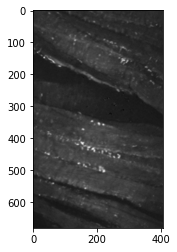

In [2]:
# loading dataset
data_dir = '/home/arya1080/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
filenames = os.listdir(data_dir)
# print(filenames)
img_stack = []
for files in filenames:
    img = io.imread(data_dir + files)
    plt.imshow(img[:,:,5], cmap='gray')
#     plt.show()
    img_stack.append(img)

In [3]:
# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')
print(img_stack.shape)

(25, 681, 406, 9)


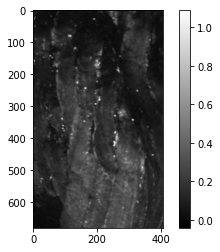

In [4]:
# choose a slice and show
plt.imshow(img_stack[2,:,:,5], cmap = 'gray')
plt.colorbar()
plt.show()

In [5]:
# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

img width = 681, img height = 406, img channels = 9


# Define model

In [6]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, 3, kernel_size=1, stride=1),
            Sigmoid()
        )
        
        """The spectral autoencoder has a bottleneck in the number of channels instead of upsampling and downsampling layers"""
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 64, kernel_size=1, stride=1),
            ReLU(inplace=True),
            
            # Defining another 2D convolution layer
            Conv2d(64, nch, kernel_size=1, stride=1),            
            
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.cnn_spectral_layers(x)
        return x
    
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z

In [7]:
# instantiate the model by calling the function
model = Net()
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
  )
  (cnn_spectral_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [8]:
# define loss function
criterion = nn.L1Loss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# set the model training device
"""cuda:0 for GPU 0, cuda:1 for GPU1, cpu for CPU"""
device = 'cuda:0'
print(device)
model.to(device) # load the model in the training device

cuda:0


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
  )
  (cnn_spectral_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [10]:
# prepare the input data before training
img_stack = torch.tensor(img_stack)
print(img_stack.shape)
img_stack = img_stack.to(device)

torch.Size([25, 681, 406, 9])


In [11]:
# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    return img

# Train model

  0%|                                          | 1/1000 [00:00<05:35,  2.98it/s]

Epoch: 1 	Training Loss: 0.073415


  0%|                                          | 2/1000 [00:00<05:16,  3.15it/s]

Epoch: 2 	Training Loss: 0.062955


  0%|▏                                         | 3/1000 [00:00<05:11,  3.20it/s]

Epoch: 3 	Training Loss: 0.052242


  0%|▏                                         | 4/1000 [00:01<05:08,  3.23it/s]

Epoch: 4 	Training Loss: 0.032587


  0%|▏                                         | 5/1000 [00:01<05:07,  3.24it/s]

Epoch: 5 	Training Loss: 0.022111


  1%|▎                                         | 6/1000 [00:01<05:05,  3.25it/s]

Epoch: 6 	Training Loss: 0.018892


  1%|▎                                         | 7/1000 [00:02<05:05,  3.25it/s]

Epoch: 7 	Training Loss: 0.016814


  1%|▎                                         | 8/1000 [00:02<05:04,  3.25it/s]

Epoch: 8 	Training Loss: 0.015876


  1%|▍                                         | 9/1000 [00:02<05:04,  3.26it/s]

Epoch: 9 	Training Loss: 0.015929


  1%|▍                                        | 10/1000 [00:03<05:03,  3.26it/s]

Epoch: 10 	Training Loss: 0.015270


  1%|▍                                        | 11/1000 [00:03<05:03,  3.26it/s]

Epoch: 11 	Training Loss: 0.014952


  1%|▍                                        | 12/1000 [00:03<05:03,  3.26it/s]

Epoch: 12 	Training Loss: 0.014557


  1%|▌                                        | 13/1000 [00:04<05:02,  3.26it/s]

Epoch: 13 	Training Loss: 0.014457


  1%|▌                                        | 14/1000 [00:04<05:02,  3.26it/s]

Epoch: 14 	Training Loss: 0.014293


  2%|▌                                        | 15/1000 [00:04<05:01,  3.26it/s]

Epoch: 15 	Training Loss: 0.014073


  2%|▋                                        | 16/1000 [00:04<05:01,  3.26it/s]

Epoch: 16 	Training Loss: 0.013781


  2%|▋                                        | 17/1000 [00:05<05:01,  3.26it/s]

Epoch: 17 	Training Loss: 0.013545


  2%|▋                                        | 18/1000 [00:05<05:00,  3.26it/s]

Epoch: 18 	Training Loss: 0.013260


  2%|▊                                        | 19/1000 [00:05<05:00,  3.26it/s]

Epoch: 19 	Training Loss: 0.013058


  2%|▊                                        | 20/1000 [00:06<05:00,  3.26it/s]

Epoch: 20 	Training Loss: 0.013106


  2%|▊                                        | 21/1000 [00:06<05:00,  3.26it/s]

Epoch: 21 	Training Loss: 0.012656


  2%|▉                                        | 22/1000 [00:06<04:59,  3.26it/s]

Epoch: 22 	Training Loss: 0.012606


  2%|▉                                        | 23/1000 [00:07<04:59,  3.26it/s]

Epoch: 23 	Training Loss: 0.011966


  2%|▉                                        | 24/1000 [00:07<04:59,  3.26it/s]

Epoch: 24 	Training Loss: 0.012289


  2%|█                                        | 25/1000 [00:07<04:59,  3.26it/s]

Epoch: 25 	Training Loss: 0.012857


  3%|█                                        | 26/1000 [00:07<04:58,  3.26it/s]

Epoch: 26 	Training Loss: 0.010206


  3%|█                                        | 27/1000 [00:08<04:58,  3.26it/s]

Epoch: 27 	Training Loss: 0.010067


  3%|█▏                                       | 28/1000 [00:08<04:58,  3.26it/s]

Epoch: 28 	Training Loss: 0.009413


  3%|█▏                                       | 29/1000 [00:08<04:57,  3.26it/s]

Epoch: 29 	Training Loss: 0.009292


  3%|█▏                                       | 30/1000 [00:09<04:57,  3.26it/s]

Epoch: 30 	Training Loss: 0.009266


  3%|█▎                                       | 31/1000 [00:09<04:57,  3.26it/s]

Epoch: 31 	Training Loss: 0.009370


  3%|█▎                                       | 32/1000 [00:09<04:56,  3.26it/s]

Epoch: 32 	Training Loss: 0.009534


  3%|█▎                                       | 33/1000 [00:10<04:56,  3.26it/s]

Epoch: 33 	Training Loss: 0.009572


  3%|█▍                                       | 34/1000 [00:10<04:56,  3.26it/s]

Epoch: 34 	Training Loss: 0.009668


  4%|█▍                                       | 35/1000 [00:10<04:55,  3.26it/s]

Epoch: 35 	Training Loss: 0.008518


  4%|█▍                                       | 36/1000 [00:11<04:55,  3.26it/s]

Epoch: 36 	Training Loss: 0.009118


  4%|█▌                                       | 37/1000 [00:11<04:55,  3.26it/s]

Epoch: 37 	Training Loss: 0.008146


  4%|█▌                                       | 38/1000 [00:11<04:55,  3.26it/s]

Epoch: 38 	Training Loss: 0.008277


  4%|█▌                                       | 39/1000 [00:11<04:54,  3.26it/s]

Epoch: 39 	Training Loss: 0.008147


  4%|█▋                                       | 40/1000 [00:12<04:54,  3.26it/s]

Epoch: 40 	Training Loss: 0.007806


  4%|█▋                                       | 41/1000 [00:12<04:54,  3.26it/s]

Epoch: 41 	Training Loss: 0.008178


  4%|█▋                                       | 42/1000 [00:12<04:53,  3.26it/s]

Epoch: 42 	Training Loss: 0.008202


  4%|█▊                                       | 43/1000 [00:13<04:53,  3.26it/s]

Epoch: 43 	Training Loss: 0.007945


  4%|█▊                                       | 44/1000 [00:13<04:53,  3.26it/s]

Epoch: 44 	Training Loss: 0.008108


  4%|█▊                                       | 45/1000 [00:13<04:53,  3.26it/s]

Epoch: 45 	Training Loss: 0.008177


  5%|█▉                                       | 46/1000 [00:14<04:52,  3.26it/s]

Epoch: 46 	Training Loss: 0.008273


  5%|█▉                                       | 47/1000 [00:14<04:52,  3.26it/s]

Epoch: 47 	Training Loss: 0.009594


  5%|█▉                                       | 48/1000 [00:14<04:52,  3.26it/s]

Epoch: 48 	Training Loss: 0.007974


  5%|██                                       | 49/1000 [00:15<04:51,  3.26it/s]

Epoch: 49 	Training Loss: 0.007948
Epoch: 50 	Training Loss: 0.008621


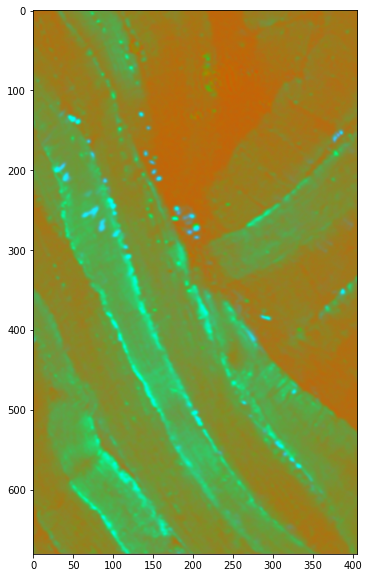

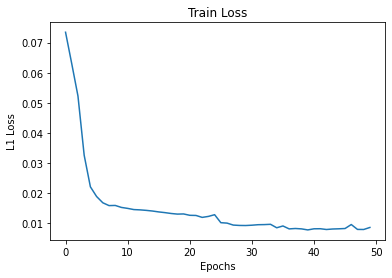

  5%|██                                       | 51/1000 [00:15<05:37,  2.81it/s]

Epoch: 51 	Training Loss: 0.007877


  5%|██▏                                      | 52/1000 [00:16<05:23,  2.93it/s]

Epoch: 52 	Training Loss: 0.008020


  5%|██▏                                      | 53/1000 [00:16<05:13,  3.02it/s]

Epoch: 53 	Training Loss: 0.007914


  5%|██▏                                      | 54/1000 [00:16<05:06,  3.08it/s]

Epoch: 54 	Training Loss: 0.007969


  6%|██▎                                      | 55/1000 [00:17<05:01,  3.13it/s]

Epoch: 55 	Training Loss: 0.008655


  6%|██▎                                      | 56/1000 [00:17<04:57,  3.17it/s]

Epoch: 56 	Training Loss: 0.007837


  6%|██▎                                      | 57/1000 [00:17<04:55,  3.19it/s]

Epoch: 57 	Training Loss: 0.007813


  6%|██▍                                      | 58/1000 [00:18<04:53,  3.21it/s]

Epoch: 58 	Training Loss: 0.007498


  6%|██▍                                      | 59/1000 [00:18<04:51,  3.23it/s]

Epoch: 59 	Training Loss: 0.007471


  6%|██▍                                      | 60/1000 [00:18<04:50,  3.23it/s]

Epoch: 60 	Training Loss: 0.007696


  6%|██▌                                      | 61/1000 [00:18<04:49,  3.24it/s]

Epoch: 61 	Training Loss: 0.007822


  6%|██▌                                      | 62/1000 [00:19<04:49,  3.24it/s]

Epoch: 62 	Training Loss: 0.008474


  6%|██▌                                      | 63/1000 [00:19<04:48,  3.25it/s]

Epoch: 63 	Training Loss: 0.007912


  6%|██▌                                      | 64/1000 [00:19<04:48,  3.25it/s]

Epoch: 64 	Training Loss: 0.007848


  6%|██▋                                      | 65/1000 [00:20<04:47,  3.25it/s]

Epoch: 65 	Training Loss: 0.007645


  7%|██▋                                      | 66/1000 [00:20<04:47,  3.25it/s]

Epoch: 66 	Training Loss: 0.008002


  7%|██▋                                      | 67/1000 [00:20<04:46,  3.25it/s]

Epoch: 67 	Training Loss: 0.007840


  7%|██▊                                      | 68/1000 [00:21<04:46,  3.25it/s]

Epoch: 68 	Training Loss: 0.007710


  7%|██▊                                      | 69/1000 [00:21<04:46,  3.25it/s]

Epoch: 69 	Training Loss: 0.007358


  7%|██▊                                      | 70/1000 [00:21<04:46,  3.25it/s]

Epoch: 70 	Training Loss: 0.007293


  7%|██▉                                      | 71/1000 [00:22<04:45,  3.25it/s]

Epoch: 71 	Training Loss: 0.007521


  7%|██▉                                      | 72/1000 [00:22<04:45,  3.25it/s]

Epoch: 72 	Training Loss: 0.007334


  7%|██▉                                      | 73/1000 [00:22<04:45,  3.25it/s]

Epoch: 73 	Training Loss: 0.008047


  7%|███                                      | 74/1000 [00:22<04:45,  3.25it/s]

Epoch: 74 	Training Loss: 0.009517


  8%|███                                      | 75/1000 [00:23<04:44,  3.25it/s]

Epoch: 75 	Training Loss: 0.008182


  8%|███                                      | 76/1000 [00:23<04:44,  3.25it/s]

Epoch: 76 	Training Loss: 0.007928


  8%|███▏                                     | 77/1000 [00:23<04:44,  3.25it/s]

Epoch: 77 	Training Loss: 0.007663


  8%|███▏                                     | 78/1000 [00:24<04:43,  3.25it/s]

Epoch: 78 	Training Loss: 0.007424


  8%|███▏                                     | 79/1000 [00:24<04:43,  3.25it/s]

Epoch: 79 	Training Loss: 0.007841


  8%|███▎                                     | 80/1000 [00:24<04:43,  3.25it/s]

Epoch: 80 	Training Loss: 0.008733


  8%|███▎                                     | 81/1000 [00:25<04:43,  3.25it/s]

Epoch: 81 	Training Loss: 0.007838


  8%|███▎                                     | 82/1000 [00:25<04:42,  3.25it/s]

Epoch: 82 	Training Loss: 0.007539


  8%|███▍                                     | 83/1000 [00:25<04:42,  3.25it/s]

Epoch: 83 	Training Loss: 0.007299


  8%|███▍                                     | 84/1000 [00:26<04:42,  3.25it/s]

Epoch: 84 	Training Loss: 0.007301


  8%|███▍                                     | 85/1000 [00:26<04:41,  3.25it/s]

Epoch: 85 	Training Loss: 0.007597


  9%|███▌                                     | 86/1000 [00:26<04:41,  3.25it/s]

Epoch: 86 	Training Loss: 0.007903


  9%|███▌                                     | 87/1000 [00:26<04:41,  3.25it/s]

Epoch: 87 	Training Loss: 0.007535


  9%|███▌                                     | 88/1000 [00:27<04:41,  3.24it/s]

Epoch: 88 	Training Loss: 0.007279


  9%|███▋                                     | 89/1000 [00:27<04:40,  3.25it/s]

Epoch: 89 	Training Loss: 0.007345


  9%|███▋                                     | 90/1000 [00:27<04:40,  3.25it/s]

Epoch: 90 	Training Loss: 0.007246


  9%|███▋                                     | 91/1000 [00:28<04:40,  3.24it/s]

Epoch: 91 	Training Loss: 0.007247


  9%|███▊                                     | 92/1000 [00:28<04:39,  3.24it/s]

Epoch: 92 	Training Loss: 0.007159


  9%|███▊                                     | 93/1000 [00:28<04:39,  3.24it/s]

Epoch: 93 	Training Loss: 0.007322


  9%|███▊                                     | 94/1000 [00:29<04:39,  3.24it/s]

Epoch: 94 	Training Loss: 0.007254


 10%|███▉                                     | 95/1000 [00:29<04:39,  3.24it/s]

Epoch: 95 	Training Loss: 0.007245


 10%|███▉                                     | 96/1000 [00:29<04:38,  3.24it/s]

Epoch: 96 	Training Loss: 0.007263


 10%|███▉                                     | 97/1000 [00:30<04:38,  3.24it/s]

Epoch: 97 	Training Loss: 0.007306


 10%|████                                     | 98/1000 [00:30<04:38,  3.24it/s]

Epoch: 98 	Training Loss: 0.007254


 10%|████                                     | 99/1000 [00:30<04:37,  3.24it/s]

Epoch: 99 	Training Loss: 0.007535
Epoch: 100 	Training Loss: 0.007291


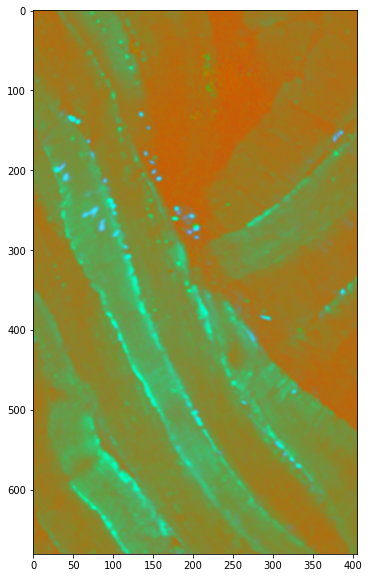

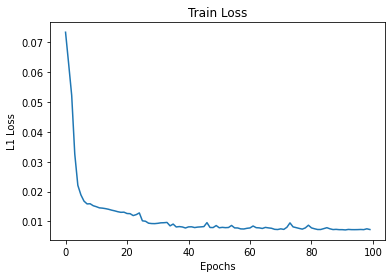

 10%|████                                    | 101/1000 [00:31<05:19,  2.82it/s]

Epoch: 101 	Training Loss: 0.007955


 10%|████                                    | 102/1000 [00:31<05:06,  2.93it/s]

Epoch: 102 	Training Loss: 0.008923


 10%|████                                    | 103/1000 [00:32<04:57,  3.02it/s]

Epoch: 103 	Training Loss: 0.008044


 10%|████▏                                   | 104/1000 [00:32<04:50,  3.08it/s]

Epoch: 104 	Training Loss: 0.007395


 10%|████▏                                   | 105/1000 [00:32<04:45,  3.13it/s]

Epoch: 105 	Training Loss: 0.007430


 11%|████▏                                   | 106/1000 [00:33<04:42,  3.16it/s]

Epoch: 106 	Training Loss: 0.008377


 11%|████▎                                   | 107/1000 [00:33<04:40,  3.18it/s]

Epoch: 107 	Training Loss: 0.008754


 11%|████▎                                   | 108/1000 [00:33<04:38,  3.20it/s]

Epoch: 108 	Training Loss: 0.009958


 11%|████▎                                   | 109/1000 [00:33<04:37,  3.22it/s]

Epoch: 109 	Training Loss: 0.007816


 11%|████▍                                   | 110/1000 [00:34<04:36,  3.22it/s]

Epoch: 110 	Training Loss: 0.007330


 11%|████▍                                   | 111/1000 [00:34<04:35,  3.23it/s]

Epoch: 111 	Training Loss: 0.007338


 11%|████▍                                   | 112/1000 [00:34<04:34,  3.23it/s]

Epoch: 112 	Training Loss: 0.007354


 11%|████▌                                   | 113/1000 [00:35<04:34,  3.23it/s]

Epoch: 113 	Training Loss: 0.007447


 11%|████▌                                   | 114/1000 [00:35<04:33,  3.23it/s]

Epoch: 114 	Training Loss: 0.007219


 12%|████▌                                   | 115/1000 [00:35<04:33,  3.24it/s]

Epoch: 115 	Training Loss: 0.007463


 12%|████▋                                   | 116/1000 [00:36<04:32,  3.24it/s]

Epoch: 116 	Training Loss: 0.008122


 12%|████▋                                   | 117/1000 [00:36<04:32,  3.24it/s]

Epoch: 117 	Training Loss: 0.007791


 12%|████▋                                   | 118/1000 [00:36<04:32,  3.24it/s]

Epoch: 118 	Training Loss: 0.007466


 12%|████▊                                   | 119/1000 [00:37<04:31,  3.24it/s]

Epoch: 119 	Training Loss: 0.007202


 12%|████▊                                   | 120/1000 [00:37<04:31,  3.24it/s]

Epoch: 120 	Training Loss: 0.007082


 12%|████▊                                   | 121/1000 [00:37<04:31,  3.24it/s]

Epoch: 121 	Training Loss: 0.007054


 12%|████▉                                   | 122/1000 [00:37<04:31,  3.24it/s]

Epoch: 122 	Training Loss: 0.007084


 12%|████▉                                   | 123/1000 [00:38<04:30,  3.24it/s]

Epoch: 123 	Training Loss: 0.007111


 12%|████▉                                   | 124/1000 [00:38<04:30,  3.24it/s]

Epoch: 124 	Training Loss: 0.007057


 12%|█████                                   | 125/1000 [00:38<04:30,  3.24it/s]

Epoch: 125 	Training Loss: 0.007045


 13%|█████                                   | 126/1000 [00:39<04:29,  3.24it/s]

Epoch: 126 	Training Loss: 0.007044


 13%|█████                                   | 127/1000 [00:39<04:29,  3.24it/s]

Epoch: 127 	Training Loss: 0.007327


 13%|█████                                   | 128/1000 [00:39<04:29,  3.24it/s]

Epoch: 128 	Training Loss: 0.008095


 13%|█████▏                                  | 129/1000 [00:40<04:28,  3.24it/s]

Epoch: 129 	Training Loss: 0.009065


 13%|█████▏                                  | 130/1000 [00:40<04:28,  3.24it/s]

Epoch: 130 	Training Loss: 0.008983


 13%|█████▏                                  | 131/1000 [00:40<04:28,  3.24it/s]

Epoch: 131 	Training Loss: 0.008038


 13%|█████▎                                  | 132/1000 [00:41<04:27,  3.24it/s]

Epoch: 132 	Training Loss: 0.007453


 13%|█████▎                                  | 133/1000 [00:41<04:27,  3.24it/s]

Epoch: 133 	Training Loss: 0.007379


 13%|█████▎                                  | 134/1000 [00:41<04:27,  3.24it/s]

Epoch: 134 	Training Loss: 0.007267


 14%|█████▍                                  | 135/1000 [00:42<04:26,  3.24it/s]

Epoch: 135 	Training Loss: 0.007150


 14%|█████▍                                  | 136/1000 [00:42<04:26,  3.24it/s]

Epoch: 136 	Training Loss: 0.007134


 14%|█████▍                                  | 137/1000 [00:42<04:26,  3.24it/s]

Epoch: 137 	Training Loss: 0.007204


 14%|█████▌                                  | 138/1000 [00:42<04:26,  3.24it/s]

Epoch: 138 	Training Loss: 0.007606


 14%|█████▌                                  | 139/1000 [00:43<04:25,  3.24it/s]

Epoch: 139 	Training Loss: 0.008048


 14%|█████▌                                  | 140/1000 [00:43<04:25,  3.24it/s]

Epoch: 140 	Training Loss: 0.007998


 14%|█████▋                                  | 141/1000 [00:43<04:25,  3.24it/s]

Epoch: 141 	Training Loss: 0.007867


 14%|█████▋                                  | 142/1000 [00:44<04:24,  3.24it/s]

Epoch: 142 	Training Loss: 0.007988


 14%|█████▋                                  | 143/1000 [00:44<04:24,  3.24it/s]

Epoch: 143 	Training Loss: 0.007489


 14%|█████▊                                  | 144/1000 [00:44<04:24,  3.24it/s]

Epoch: 144 	Training Loss: 0.007239


 14%|█████▊                                  | 145/1000 [00:45<04:23,  3.24it/s]

Epoch: 145 	Training Loss: 0.007265


 15%|█████▊                                  | 146/1000 [00:45<04:23,  3.24it/s]

Epoch: 146 	Training Loss: 0.007206


 15%|█████▉                                  | 147/1000 [00:45<04:23,  3.24it/s]

Epoch: 147 	Training Loss: 0.007118


 15%|█████▉                                  | 148/1000 [00:46<04:23,  3.24it/s]

Epoch: 148 	Training Loss: 0.007408


 15%|█████▉                                  | 149/1000 [00:46<04:22,  3.24it/s]

Epoch: 149 	Training Loss: 0.007675
Epoch: 150 	Training Loss: 0.007791


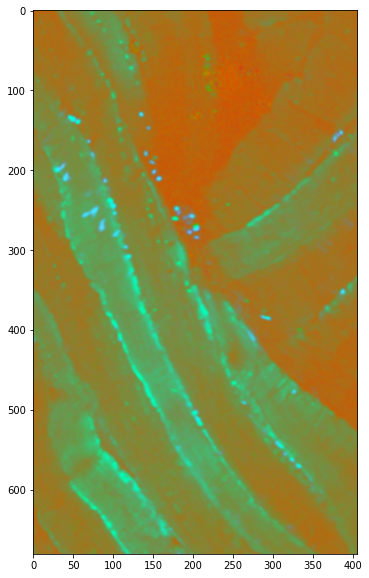

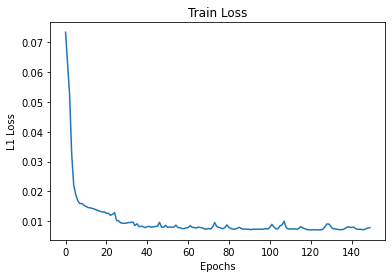

 15%|██████                                  | 151/1000 [00:47<05:02,  2.81it/s]

Epoch: 151 	Training Loss: 0.007575


 15%|██████                                  | 152/1000 [00:47<04:49,  2.93it/s]

Epoch: 152 	Training Loss: 0.007445


 15%|██████                                  | 153/1000 [00:47<04:41,  3.01it/s]

Epoch: 153 	Training Loss: 0.007344


 15%|██████▏                                 | 154/1000 [00:48<04:35,  3.07it/s]

Epoch: 154 	Training Loss: 0.007151


 16%|██████▏                                 | 155/1000 [00:48<04:30,  3.12it/s]

Epoch: 155 	Training Loss: 0.007005


 16%|██████▏                                 | 156/1000 [00:48<04:27,  3.16it/s]

Epoch: 156 	Training Loss: 0.007302


 16%|██████▎                                 | 157/1000 [00:49<04:25,  3.18it/s]

Epoch: 157 	Training Loss: 0.007491


 16%|██████▎                                 | 158/1000 [00:49<04:23,  3.19it/s]

Epoch: 158 	Training Loss: 0.007177


 16%|██████▎                                 | 159/1000 [00:49<04:22,  3.21it/s]

Epoch: 159 	Training Loss: 0.006976


 16%|██████▍                                 | 160/1000 [00:49<04:21,  3.21it/s]

Epoch: 160 	Training Loss: 0.006973


 16%|██████▍                                 | 161/1000 [00:50<04:20,  3.22it/s]

Epoch: 161 	Training Loss: 0.006963


 16%|██████▍                                 | 162/1000 [00:50<04:19,  3.23it/s]

Epoch: 162 	Training Loss: 0.007046


 16%|██████▌                                 | 163/1000 [00:50<04:19,  3.23it/s]

Epoch: 163 	Training Loss: 0.007076


 16%|██████▌                                 | 164/1000 [00:51<04:18,  3.23it/s]

Epoch: 164 	Training Loss: 0.006996


 16%|██████▌                                 | 165/1000 [00:51<04:18,  3.23it/s]

Epoch: 165 	Training Loss: 0.007149


 17%|██████▋                                 | 166/1000 [00:51<04:17,  3.23it/s]

Epoch: 166 	Training Loss: 0.007335


 17%|██████▋                                 | 167/1000 [00:52<04:17,  3.23it/s]

Epoch: 167 	Training Loss: 0.007771


 17%|██████▋                                 | 168/1000 [00:52<04:17,  3.23it/s]

Epoch: 168 	Training Loss: 0.009263


 17%|██████▊                                 | 169/1000 [00:52<04:16,  3.23it/s]

Epoch: 169 	Training Loss: 0.007776


 17%|██████▊                                 | 170/1000 [00:53<04:16,  3.23it/s]

Epoch: 170 	Training Loss: 0.007415


 17%|██████▊                                 | 171/1000 [00:53<04:16,  3.23it/s]

Epoch: 171 	Training Loss: 0.007222


 17%|██████▉                                 | 172/1000 [00:53<04:15,  3.23it/s]

Epoch: 172 	Training Loss: 0.007262


 17%|██████▉                                 | 173/1000 [00:53<04:15,  3.23it/s]

Epoch: 173 	Training Loss: 0.007109


 17%|██████▉                                 | 174/1000 [00:54<04:15,  3.23it/s]

Epoch: 174 	Training Loss: 0.007354


 18%|███████                                 | 175/1000 [00:54<04:15,  3.23it/s]

Epoch: 175 	Training Loss: 0.007386


 18%|███████                                 | 176/1000 [00:54<04:14,  3.23it/s]

Epoch: 176 	Training Loss: 0.007209


 18%|███████                                 | 177/1000 [00:55<04:14,  3.23it/s]

Epoch: 177 	Training Loss: 0.007419


 18%|███████                                 | 178/1000 [00:55<04:14,  3.23it/s]

Epoch: 178 	Training Loss: 0.007278


 18%|███████▏                                | 179/1000 [00:55<04:13,  3.23it/s]

Epoch: 179 	Training Loss: 0.007397


 18%|███████▏                                | 180/1000 [00:56<04:13,  3.23it/s]

Epoch: 180 	Training Loss: 0.007347


 18%|███████▏                                | 181/1000 [00:56<04:13,  3.23it/s]

Epoch: 181 	Training Loss: 0.007041


 18%|███████▎                                | 182/1000 [00:56<04:12,  3.23it/s]

Epoch: 182 	Training Loss: 0.007414


 18%|███████▎                                | 183/1000 [00:57<04:12,  3.23it/s]

Epoch: 183 	Training Loss: 0.007846


 18%|███████▎                                | 184/1000 [00:57<04:12,  3.23it/s]

Epoch: 184 	Training Loss: 0.007589


 18%|███████▍                                | 185/1000 [00:57<04:12,  3.23it/s]

Epoch: 185 	Training Loss: 0.007516


 19%|███████▍                                | 186/1000 [00:58<04:11,  3.23it/s]

Epoch: 186 	Training Loss: 0.007299


 19%|███████▍                                | 187/1000 [00:58<04:11,  3.23it/s]

Epoch: 187 	Training Loss: 0.007033


 19%|███████▌                                | 188/1000 [00:58<04:11,  3.23it/s]

Epoch: 188 	Training Loss: 0.007119


 19%|███████▌                                | 189/1000 [00:58<04:10,  3.23it/s]

Epoch: 189 	Training Loss: 0.007331


 19%|███████▌                                | 190/1000 [00:59<04:10,  3.23it/s]

Epoch: 190 	Training Loss: 0.007258


 19%|███████▋                                | 191/1000 [00:59<04:10,  3.23it/s]

Epoch: 191 	Training Loss: 0.007299


 19%|███████▋                                | 192/1000 [00:59<04:10,  3.23it/s]

Epoch: 192 	Training Loss: 0.007262


 19%|███████▋                                | 193/1000 [01:00<04:09,  3.23it/s]

Epoch: 193 	Training Loss: 0.007280


 19%|███████▊                                | 194/1000 [01:00<04:09,  3.23it/s]

Epoch: 194 	Training Loss: 0.007260


 20%|███████▊                                | 195/1000 [01:00<04:09,  3.23it/s]

Epoch: 195 	Training Loss: 0.007276


 20%|███████▊                                | 196/1000 [01:01<04:08,  3.23it/s]

Epoch: 196 	Training Loss: 0.007285


 20%|███████▉                                | 197/1000 [01:01<04:08,  3.23it/s]

Epoch: 197 	Training Loss: 0.007287


 20%|███████▉                                | 198/1000 [01:01<04:08,  3.23it/s]

Epoch: 198 	Training Loss: 0.007247


 20%|███████▉                                | 199/1000 [01:02<04:08,  3.23it/s]

Epoch: 199 	Training Loss: 0.007289
Epoch: 200 	Training Loss: 0.007252


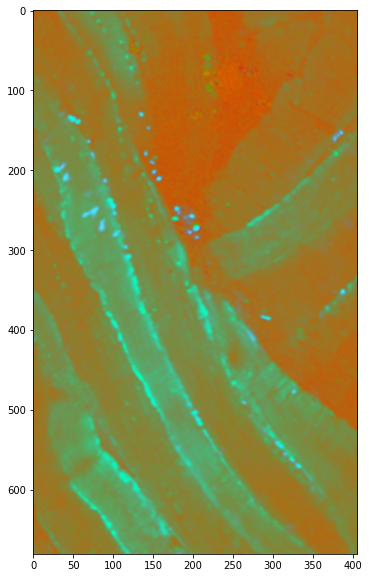

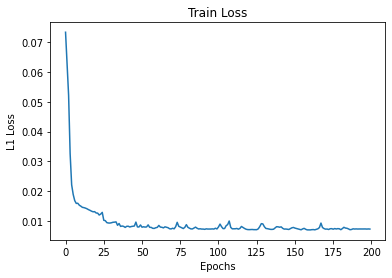

 20%|████████                                | 201/1000 [01:02<04:45,  2.79it/s]

Epoch: 201 	Training Loss: 0.007251


 20%|████████                                | 202/1000 [01:03<04:33,  2.91it/s]

Epoch: 202 	Training Loss: 0.007248


 20%|████████                                | 203/1000 [01:03<04:25,  3.00it/s]

Epoch: 203 	Training Loss: 0.007283


 20%|████████▏                               | 204/1000 [01:03<04:20,  3.06it/s]

Epoch: 204 	Training Loss: 0.007233


 20%|████████▏                               | 205/1000 [01:04<04:15,  3.11it/s]

Epoch: 205 	Training Loss: 0.007286


 21%|████████▏                               | 206/1000 [01:04<04:12,  3.15it/s]

Epoch: 206 	Training Loss: 0.007260


 21%|████████▎                               | 207/1000 [01:04<04:10,  3.16it/s]

Epoch: 207 	Training Loss: 0.007246


 21%|████████▎                               | 208/1000 [01:05<04:08,  3.18it/s]

Epoch: 208 	Training Loss: 0.007234


 21%|████████▎                               | 209/1000 [01:05<04:07,  3.20it/s]

Epoch: 209 	Training Loss: 0.007271


 21%|████████▍                               | 210/1000 [01:05<04:06,  3.20it/s]

Epoch: 210 	Training Loss: 0.007195


 21%|████████▍                               | 211/1000 [01:05<04:05,  3.21it/s]

Epoch: 211 	Training Loss: 0.007178


 21%|████████▍                               | 212/1000 [01:06<04:05,  3.22it/s]

Epoch: 212 	Training Loss: 0.007245


 21%|████████▌                               | 213/1000 [01:06<04:04,  3.22it/s]

Epoch: 213 	Training Loss: 0.007275


 21%|████████▌                               | 214/1000 [01:06<04:04,  3.22it/s]

Epoch: 214 	Training Loss: 0.007047


 22%|████████▌                               | 215/1000 [01:07<04:03,  3.22it/s]

Epoch: 215 	Training Loss: 0.007119


 22%|████████▋                               | 216/1000 [01:07<04:03,  3.22it/s]

Epoch: 216 	Training Loss: 0.007241


 22%|████████▋                               | 217/1000 [01:07<04:03,  3.22it/s]

Epoch: 217 	Training Loss: 0.007299


 22%|████████▋                               | 218/1000 [01:08<04:02,  3.22it/s]

Epoch: 218 	Training Loss: 0.007127


 22%|████████▊                               | 219/1000 [01:08<04:02,  3.22it/s]

Epoch: 219 	Training Loss: 0.007345


 22%|████████▊                               | 220/1000 [01:08<04:02,  3.22it/s]

Epoch: 220 	Training Loss: 0.007420


 22%|████████▊                               | 221/1000 [01:09<04:01,  3.22it/s]

Epoch: 221 	Training Loss: 0.007114


 22%|████████▉                               | 222/1000 [01:09<04:01,  3.22it/s]

Epoch: 222 	Training Loss: 0.007168


 22%|████████▉                               | 223/1000 [01:09<04:01,  3.22it/s]

Epoch: 223 	Training Loss: 0.007222


 22%|████████▉                               | 224/1000 [01:10<04:00,  3.22it/s]

Epoch: 224 	Training Loss: 0.007269


 22%|█████████                               | 225/1000 [01:10<04:00,  3.22it/s]

Epoch: 225 	Training Loss: 0.007100


 23%|█████████                               | 226/1000 [01:10<04:00,  3.22it/s]

Epoch: 226 	Training Loss: 0.007312


 23%|█████████                               | 227/1000 [01:10<03:59,  3.22it/s]

Epoch: 227 	Training Loss: 0.007502


 23%|█████████                               | 228/1000 [01:11<03:59,  3.22it/s]

Epoch: 228 	Training Loss: 0.007037


 23%|█████████▏                              | 229/1000 [01:11<03:59,  3.22it/s]

Epoch: 229 	Training Loss: 0.006920


 23%|█████████▏                              | 230/1000 [01:11<03:59,  3.22it/s]

Epoch: 230 	Training Loss: 0.007013


 23%|█████████▏                              | 231/1000 [01:12<03:58,  3.22it/s]

Epoch: 231 	Training Loss: 0.007216


 23%|█████████▎                              | 232/1000 [01:12<03:58,  3.22it/s]

Epoch: 232 	Training Loss: 0.007265


 23%|█████████▎                              | 233/1000 [01:12<03:58,  3.22it/s]

Epoch: 233 	Training Loss: 0.007136


 23%|█████████▎                              | 234/1000 [01:13<03:57,  3.22it/s]

Epoch: 234 	Training Loss: 0.007204


 24%|█████████▍                              | 235/1000 [01:13<03:57,  3.22it/s]

Epoch: 235 	Training Loss: 0.006957


 24%|█████████▍                              | 236/1000 [01:13<03:57,  3.22it/s]

Epoch: 236 	Training Loss: 0.007137


 24%|█████████▍                              | 237/1000 [01:14<03:56,  3.22it/s]

Epoch: 237 	Training Loss: 0.007248


 24%|█████████▌                              | 238/1000 [01:14<03:56,  3.22it/s]

Epoch: 238 	Training Loss: 0.007180


 24%|█████████▌                              | 239/1000 [01:14<03:56,  3.22it/s]

Epoch: 239 	Training Loss: 0.007289


 24%|█████████▌                              | 240/1000 [01:14<03:55,  3.22it/s]

Epoch: 240 	Training Loss: 0.007265


 24%|█████████▋                              | 241/1000 [01:15<03:55,  3.22it/s]

Epoch: 241 	Training Loss: 0.006948


 24%|█████████▋                              | 242/1000 [01:15<03:55,  3.22it/s]

Epoch: 242 	Training Loss: 0.007218


 24%|█████████▋                              | 243/1000 [01:15<03:55,  3.22it/s]

Epoch: 243 	Training Loss: 0.007312


 24%|█████████▊                              | 244/1000 [01:16<03:54,  3.22it/s]

Epoch: 244 	Training Loss: 0.007210


 24%|█████████▊                              | 245/1000 [01:16<03:54,  3.22it/s]

Epoch: 245 	Training Loss: 0.007179


 25%|█████████▊                              | 246/1000 [01:16<03:54,  3.22it/s]

Epoch: 246 	Training Loss: 0.007204


 25%|█████████▉                              | 247/1000 [01:17<03:53,  3.22it/s]

Epoch: 247 	Training Loss: 0.007270


 25%|█████████▉                              | 248/1000 [01:17<03:53,  3.22it/s]

Epoch: 248 	Training Loss: 0.007163


 25%|█████████▉                              | 249/1000 [01:17<03:53,  3.22it/s]

Epoch: 249 	Training Loss: 0.007157
Epoch: 250 	Training Loss: 0.007075


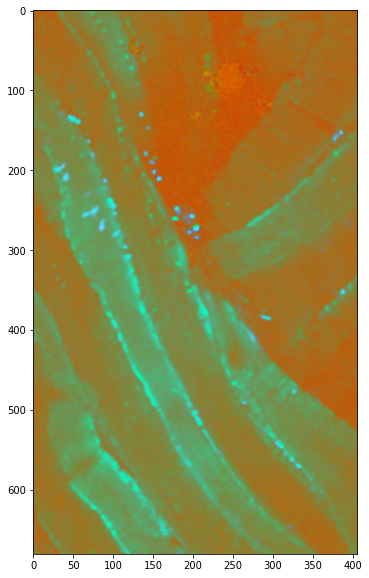

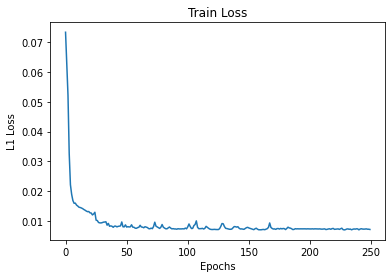

 25%|██████████                              | 251/1000 [01:18<04:38,  2.69it/s]

Epoch: 251 	Training Loss: 0.007148


 25%|██████████                              | 252/1000 [01:18<04:23,  2.84it/s]

Epoch: 252 	Training Loss: 0.006985


 25%|██████████                              | 253/1000 [01:19<04:14,  2.94it/s]

Epoch: 253 	Training Loss: 0.007317


 25%|██████████▏                             | 254/1000 [01:19<04:07,  3.02it/s]

Epoch: 254 	Training Loss: 0.007685


 26%|██████████▏                             | 255/1000 [01:19<04:02,  3.08it/s]

Epoch: 255 	Training Loss: 0.007206


 26%|██████████▏                             | 256/1000 [01:20<03:58,  3.12it/s]

Epoch: 256 	Training Loss: 0.007064


 26%|██████████▎                             | 257/1000 [01:20<03:56,  3.15it/s]

Epoch: 257 	Training Loss: 0.006962


 26%|██████████▎                             | 258/1000 [01:20<03:54,  3.17it/s]

Epoch: 258 	Training Loss: 0.006941


 26%|██████████▎                             | 259/1000 [01:21<03:52,  3.19it/s]

Epoch: 259 	Training Loss: 0.007231


 26%|██████████▍                             | 260/1000 [01:21<03:51,  3.19it/s]

Epoch: 260 	Training Loss: 0.007218


 26%|██████████▍                             | 261/1000 [01:21<03:50,  3.20it/s]

Epoch: 261 	Training Loss: 0.007176


 26%|██████████▍                             | 262/1000 [01:22<03:49,  3.21it/s]

Epoch: 262 	Training Loss: 0.007468


 26%|██████████▌                             | 263/1000 [01:22<03:49,  3.21it/s]

Epoch: 263 	Training Loss: 0.007043


 26%|██████████▌                             | 264/1000 [01:22<03:48,  3.22it/s]

Epoch: 264 	Training Loss: 0.006878


 26%|██████████▌                             | 265/1000 [01:23<03:48,  3.22it/s]

Epoch: 265 	Training Loss: 0.006891


 27%|██████████▋                             | 266/1000 [01:23<03:48,  3.22it/s]

Epoch: 266 	Training Loss: 0.006883


 27%|██████████▋                             | 267/1000 [01:23<03:47,  3.22it/s]

Epoch: 267 	Training Loss: 0.006888


 27%|██████████▋                             | 268/1000 [01:23<03:47,  3.22it/s]

Epoch: 268 	Training Loss: 0.007010


 27%|██████████▊                             | 269/1000 [01:24<03:47,  3.22it/s]

Epoch: 269 	Training Loss: 0.007468


 27%|██████████▊                             | 270/1000 [01:24<03:46,  3.22it/s]

Epoch: 270 	Training Loss: 0.007934


 27%|██████████▊                             | 271/1000 [01:24<03:46,  3.22it/s]

Epoch: 271 	Training Loss: 0.007764


 27%|██████████▉                             | 272/1000 [01:25<03:46,  3.22it/s]

Epoch: 272 	Training Loss: 0.007547


 27%|██████████▉                             | 273/1000 [01:25<03:45,  3.22it/s]

Epoch: 273 	Training Loss: 0.007230


 27%|██████████▉                             | 274/1000 [01:25<03:45,  3.22it/s]

Epoch: 274 	Training Loss: 0.007077


 28%|███████████                             | 275/1000 [01:26<03:45,  3.22it/s]

Epoch: 275 	Training Loss: 0.006967


 28%|███████████                             | 276/1000 [01:26<03:44,  3.22it/s]

Epoch: 276 	Training Loss: 0.007004


 28%|███████████                             | 277/1000 [01:26<03:44,  3.22it/s]

Epoch: 277 	Training Loss: 0.007049


 28%|███████████                             | 278/1000 [01:27<03:44,  3.22it/s]

Epoch: 278 	Training Loss: 0.006908


 28%|███████████▏                            | 279/1000 [01:27<03:43,  3.22it/s]

Epoch: 279 	Training Loss: 0.007118


 28%|███████████▏                            | 280/1000 [01:27<03:43,  3.22it/s]

Epoch: 280 	Training Loss: 0.007051


 28%|███████████▏                            | 281/1000 [01:27<03:43,  3.22it/s]

Epoch: 281 	Training Loss: 0.006841


 28%|███████████▎                            | 282/1000 [01:28<03:43,  3.22it/s]

Epoch: 282 	Training Loss: 0.006832


 28%|███████████▎                            | 283/1000 [01:28<03:42,  3.22it/s]

Epoch: 283 	Training Loss: 0.006829


 28%|███████████▎                            | 284/1000 [01:28<03:42,  3.22it/s]

Epoch: 284 	Training Loss: 0.006850


 28%|███████████▍                            | 285/1000 [01:29<03:42,  3.22it/s]

Epoch: 285 	Training Loss: 0.006857


 29%|███████████▍                            | 286/1000 [01:29<03:41,  3.22it/s]

Epoch: 286 	Training Loss: 0.006862


 29%|███████████▍                            | 287/1000 [01:29<03:41,  3.22it/s]

Epoch: 287 	Training Loss: 0.006889


 29%|███████████▌                            | 288/1000 [01:30<03:41,  3.22it/s]

Epoch: 288 	Training Loss: 0.006990


 29%|███████████▌                            | 289/1000 [01:30<03:40,  3.22it/s]

Epoch: 289 	Training Loss: 0.006920


 29%|███████████▌                            | 290/1000 [01:30<03:40,  3.22it/s]

Epoch: 290 	Training Loss: 0.007241


 29%|███████████▋                            | 291/1000 [01:31<03:40,  3.22it/s]

Epoch: 291 	Training Loss: 0.007308


 29%|███████████▋                            | 292/1000 [01:31<03:39,  3.22it/s]

Epoch: 292 	Training Loss: 0.007296


 29%|███████████▋                            | 293/1000 [01:31<03:39,  3.22it/s]

Epoch: 293 	Training Loss: 0.007831


 29%|███████████▊                            | 294/1000 [01:32<03:39,  3.22it/s]

Epoch: 294 	Training Loss: 0.007075


 30%|███████████▊                            | 295/1000 [01:32<03:39,  3.22it/s]

Epoch: 295 	Training Loss: 0.006638


 30%|███████████▊                            | 296/1000 [01:32<03:38,  3.22it/s]

Epoch: 296 	Training Loss: 0.006862


 30%|███████████▉                            | 297/1000 [01:32<03:38,  3.22it/s]

Epoch: 297 	Training Loss: 0.007259


 30%|███████████▉                            | 298/1000 [01:33<03:38,  3.22it/s]

Epoch: 298 	Training Loss: 0.007114


 30%|███████████▉                            | 299/1000 [01:33<03:37,  3.22it/s]

Epoch: 299 	Training Loss: 0.007040
Epoch: 300 	Training Loss: 0.006973


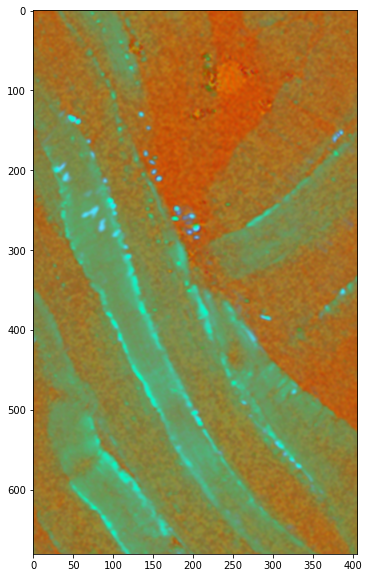

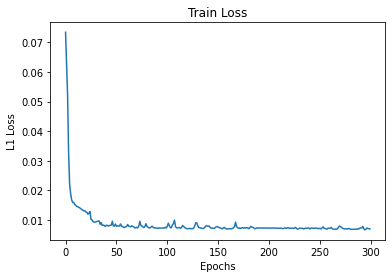

 30%|████████████                            | 301/1000 [01:34<04:12,  2.76it/s]

Epoch: 301 	Training Loss: 0.007073


 30%|████████████                            | 302/1000 [01:34<04:01,  2.89it/s]

Epoch: 302 	Training Loss: 0.007230


 30%|████████████                            | 303/1000 [01:35<03:54,  2.98it/s]

Epoch: 303 	Training Loss: 0.006763


 30%|████████████▏                           | 304/1000 [01:35<03:48,  3.04it/s]

Epoch: 304 	Training Loss: 0.006899


 30%|████████████▏                           | 305/1000 [01:35<03:44,  3.10it/s]

Epoch: 305 	Training Loss: 0.006737


 31%|████████████▏                           | 306/1000 [01:36<03:41,  3.13it/s]

Epoch: 306 	Training Loss: 0.006609


 31%|████████████▎                           | 307/1000 [01:36<03:39,  3.15it/s]

Epoch: 307 	Training Loss: 0.007079


 31%|████████████▎                           | 308/1000 [01:36<03:37,  3.18it/s]

Epoch: 308 	Training Loss: 0.007365


 31%|████████████▎                           | 309/1000 [01:36<03:36,  3.19it/s]

Epoch: 309 	Training Loss: 0.006849


 31%|████████████▍                           | 310/1000 [01:37<03:35,  3.20it/s]

Epoch: 310 	Training Loss: 0.006540


 31%|████████████▍                           | 311/1000 [01:37<03:35,  3.20it/s]

Epoch: 311 	Training Loss: 0.006949


 31%|████████████▍                           | 312/1000 [01:37<03:34,  3.21it/s]

Epoch: 312 	Training Loss: 0.006847


 31%|████████████▌                           | 313/1000 [01:38<03:33,  3.21it/s]

Epoch: 313 	Training Loss: 0.006872


 31%|████████████▌                           | 314/1000 [01:38<03:33,  3.21it/s]

Epoch: 314 	Training Loss: 0.007111


 32%|████████████▌                           | 315/1000 [01:38<03:32,  3.22it/s]

Epoch: 315 	Training Loss: 0.006589


 32%|████████████▋                           | 316/1000 [01:39<03:32,  3.22it/s]

Epoch: 316 	Training Loss: 0.006386


 32%|████████████▋                           | 317/1000 [01:39<03:32,  3.22it/s]

Epoch: 317 	Training Loss: 0.006401


 32%|████████████▋                           | 318/1000 [01:39<03:31,  3.22it/s]

Epoch: 318 	Training Loss: 0.006399


 32%|████████████▊                           | 319/1000 [01:40<03:31,  3.22it/s]

Epoch: 319 	Training Loss: 0.006550


 32%|████████████▊                           | 320/1000 [01:40<03:31,  3.22it/s]

Epoch: 320 	Training Loss: 0.007067


 32%|████████████▊                           | 321/1000 [01:40<03:30,  3.22it/s]

Epoch: 321 	Training Loss: 0.008130


 32%|████████████▉                           | 322/1000 [01:40<03:30,  3.22it/s]

Epoch: 322 	Training Loss: 0.007371


 32%|████████████▉                           | 323/1000 [01:41<03:30,  3.22it/s]

Epoch: 323 	Training Loss: 0.007017


 32%|████████████▉                           | 324/1000 [01:41<03:30,  3.22it/s]

Epoch: 324 	Training Loss: 0.006772


 32%|█████████████                           | 325/1000 [01:41<03:29,  3.22it/s]

Epoch: 325 	Training Loss: 0.006550


 33%|█████████████                           | 326/1000 [01:42<03:29,  3.22it/s]

Epoch: 326 	Training Loss: 0.006580


 33%|█████████████                           | 327/1000 [01:42<03:29,  3.22it/s]

Epoch: 327 	Training Loss: 0.006608


 33%|█████████████                           | 328/1000 [01:42<03:28,  3.22it/s]

Epoch: 328 	Training Loss: 0.006539


 33%|█████████████▏                          | 329/1000 [01:43<03:28,  3.22it/s]

Epoch: 329 	Training Loss: 0.006580


 33%|█████████████▏                          | 330/1000 [01:43<03:28,  3.22it/s]

Epoch: 330 	Training Loss: 0.006411


 33%|█████████████▏                          | 331/1000 [01:43<03:27,  3.22it/s]

Epoch: 331 	Training Loss: 0.006458


 33%|█████████████▎                          | 332/1000 [01:44<03:27,  3.22it/s]

Epoch: 332 	Training Loss: 0.006785


 33%|█████████████▎                          | 333/1000 [01:44<03:27,  3.22it/s]

Epoch: 333 	Training Loss: 0.007167


 33%|█████████████▎                          | 334/1000 [01:44<03:26,  3.22it/s]

Epoch: 334 	Training Loss: 0.006706


 34%|█████████████▍                          | 335/1000 [01:45<03:26,  3.22it/s]

Epoch: 335 	Training Loss: 0.006490


 34%|█████████████▍                          | 336/1000 [01:45<03:26,  3.22it/s]

Epoch: 336 	Training Loss: 0.006635


 34%|█████████████▍                          | 337/1000 [01:45<03:25,  3.22it/s]

Epoch: 337 	Training Loss: 0.006552


 34%|█████████████▌                          | 338/1000 [01:45<03:25,  3.22it/s]

Epoch: 338 	Training Loss: 0.006658


 34%|█████████████▌                          | 339/1000 [01:46<03:25,  3.22it/s]

Epoch: 339 	Training Loss: 0.006620


 34%|█████████████▌                          | 340/1000 [01:46<03:25,  3.22it/s]

Epoch: 340 	Training Loss: 0.006603


 34%|█████████████▋                          | 341/1000 [01:46<03:24,  3.22it/s]

Epoch: 341 	Training Loss: 0.006619


 34%|█████████████▋                          | 342/1000 [01:47<03:24,  3.22it/s]

Epoch: 342 	Training Loss: 0.006577


 34%|█████████████▋                          | 343/1000 [01:47<03:24,  3.22it/s]

Epoch: 343 	Training Loss: 0.006626


 34%|█████████████▊                          | 344/1000 [01:47<03:23,  3.22it/s]

Epoch: 344 	Training Loss: 0.006560


 34%|█████████████▊                          | 345/1000 [01:48<03:23,  3.22it/s]

Epoch: 345 	Training Loss: 0.006650


 35%|█████████████▊                          | 346/1000 [01:48<03:23,  3.22it/s]

Epoch: 346 	Training Loss: 0.006575


 35%|█████████████▉                          | 347/1000 [01:48<03:23,  3.22it/s]

Epoch: 347 	Training Loss: 0.006583


 35%|█████████████▉                          | 348/1000 [01:49<03:22,  3.22it/s]

Epoch: 348 	Training Loss: 0.006496


 35%|█████████████▉                          | 349/1000 [01:49<03:22,  3.22it/s]

Epoch: 349 	Training Loss: 0.006563
Epoch: 350 	Training Loss: 0.006643


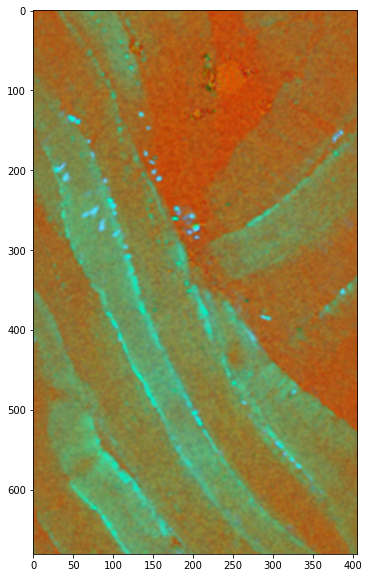

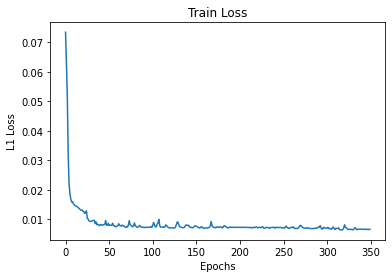

 35%|██████████████                          | 351/1000 [01:50<03:55,  2.76it/s]

Epoch: 351 	Training Loss: 0.006526


 35%|██████████████                          | 352/1000 [01:50<03:44,  2.88it/s]

Epoch: 352 	Training Loss: 0.006542


 35%|██████████████                          | 353/1000 [01:50<03:37,  2.97it/s]

Epoch: 353 	Training Loss: 0.006594


 35%|██████████████▏                         | 354/1000 [01:51<03:32,  3.04it/s]

Epoch: 354 	Training Loss: 0.006595


 36%|██████████████▏                         | 355/1000 [01:51<03:28,  3.09it/s]

Epoch: 355 	Training Loss: 0.006578


 36%|██████████████▏                         | 356/1000 [01:51<03:25,  3.13it/s]

Epoch: 356 	Training Loss: 0.006586


 36%|██████████████▎                         | 357/1000 [01:52<03:24,  3.15it/s]

Epoch: 357 	Training Loss: 0.006606


 36%|██████████████▎                         | 358/1000 [01:52<03:22,  3.17it/s]

Epoch: 358 	Training Loss: 0.006563


 36%|██████████████▎                         | 359/1000 [01:52<03:21,  3.19it/s]

Epoch: 359 	Training Loss: 0.006626


 36%|██████████████▍                         | 360/1000 [01:53<03:20,  3.19it/s]

Epoch: 360 	Training Loss: 0.006536


 36%|██████████████▍                         | 361/1000 [01:53<03:19,  3.20it/s]

Epoch: 361 	Training Loss: 0.006282


 36%|██████████████▍                         | 362/1000 [01:53<03:18,  3.21it/s]

Epoch: 362 	Training Loss: 0.006433


 36%|██████████████▌                         | 363/1000 [01:53<03:18,  3.21it/s]

Epoch: 363 	Training Loss: 0.006732


 36%|██████████████▌                         | 364/1000 [01:54<03:18,  3.21it/s]

Epoch: 364 	Training Loss: 0.006807


 36%|██████████████▌                         | 365/1000 [01:54<03:17,  3.21it/s]

Epoch: 365 	Training Loss: 0.006478


 37%|██████████████▋                         | 366/1000 [01:54<03:17,  3.21it/s]

Epoch: 366 	Training Loss: 0.006387


 37%|██████████████▋                         | 367/1000 [01:55<03:16,  3.21it/s]

Epoch: 367 	Training Loss: 0.006654


 37%|██████████████▋                         | 368/1000 [01:55<03:16,  3.22it/s]

Epoch: 368 	Training Loss: 0.006632


 37%|██████████████▊                         | 369/1000 [01:55<03:16,  3.22it/s]

Epoch: 369 	Training Loss: 0.006563


 37%|██████████████▊                         | 370/1000 [01:56<03:16,  3.21it/s]

Epoch: 370 	Training Loss: 0.006429


 37%|██████████████▊                         | 371/1000 [01:56<03:15,  3.22it/s]

Epoch: 371 	Training Loss: 0.006260


 37%|██████████████▉                         | 372/1000 [01:56<03:15,  3.22it/s]

Epoch: 372 	Training Loss: 0.006227


 37%|██████████████▉                         | 373/1000 [01:57<03:15,  3.21it/s]

Epoch: 373 	Training Loss: 0.006459


 37%|██████████████▉                         | 374/1000 [01:57<03:14,  3.21it/s]

Epoch: 374 	Training Loss: 0.006743


 38%|███████████████                         | 375/1000 [01:57<03:14,  3.22it/s]

Epoch: 375 	Training Loss: 0.006609


 38%|███████████████                         | 376/1000 [01:58<03:14,  3.22it/s]

Epoch: 376 	Training Loss: 0.006507


 38%|███████████████                         | 377/1000 [01:58<03:13,  3.22it/s]

Epoch: 377 	Training Loss: 0.006594


 38%|███████████████                         | 378/1000 [01:58<03:13,  3.22it/s]

Epoch: 378 	Training Loss: 0.006346


 38%|███████████████▏                        | 379/1000 [01:58<03:13,  3.22it/s]

Epoch: 379 	Training Loss: 0.006215


 38%|███████████████▏                        | 380/1000 [01:59<03:12,  3.22it/s]

Epoch: 380 	Training Loss: 0.006306


 38%|███████████████▏                        | 381/1000 [01:59<03:12,  3.21it/s]

Epoch: 381 	Training Loss: 0.006201


 38%|███████████████▎                        | 382/1000 [01:59<03:12,  3.21it/s]

Epoch: 382 	Training Loss: 0.006306


 38%|███████████████▎                        | 383/1000 [02:00<03:11,  3.21it/s]

Epoch: 383 	Training Loss: 0.006204


 38%|███████████████▎                        | 384/1000 [02:00<03:11,  3.21it/s]

Epoch: 384 	Training Loss: 0.006232


 38%|███████████████▍                        | 385/1000 [02:00<03:11,  3.21it/s]

Epoch: 385 	Training Loss: 0.006190


 39%|███████████████▍                        | 386/1000 [02:01<03:11,  3.21it/s]

Epoch: 386 	Training Loss: 0.006363


 39%|███████████████▍                        | 387/1000 [02:01<03:10,  3.21it/s]

Epoch: 387 	Training Loss: 0.006961


 39%|███████████████▌                        | 388/1000 [02:01<03:10,  3.21it/s]

Epoch: 388 	Training Loss: 0.007514


 39%|███████████████▌                        | 389/1000 [02:02<03:10,  3.21it/s]

Epoch: 389 	Training Loss: 0.009021


 39%|███████████████▌                        | 390/1000 [02:02<03:09,  3.21it/s]

Epoch: 390 	Training Loss: 0.007411


 39%|███████████████▋                        | 391/1000 [02:02<03:09,  3.21it/s]

Epoch: 391 	Training Loss: 0.006580


 39%|███████████████▋                        | 392/1000 [02:02<03:09,  3.21it/s]

Epoch: 392 	Training Loss: 0.006371


 39%|███████████████▋                        | 393/1000 [02:03<03:08,  3.21it/s]

Epoch: 393 	Training Loss: 0.006478


 39%|███████████████▊                        | 394/1000 [02:03<03:08,  3.21it/s]

Epoch: 394 	Training Loss: 0.006717


 40%|███████████████▊                        | 395/1000 [02:03<03:08,  3.21it/s]

Epoch: 395 	Training Loss: 0.006371


 40%|███████████████▊                        | 396/1000 [02:04<03:08,  3.21it/s]

Epoch: 396 	Training Loss: 0.006163


 40%|███████████████▉                        | 397/1000 [02:04<03:07,  3.21it/s]

Epoch: 397 	Training Loss: 0.006135


 40%|███████████████▉                        | 398/1000 [02:04<03:07,  3.21it/s]

Epoch: 398 	Training Loss: 0.006153


 40%|███████████████▉                        | 399/1000 [02:05<03:07,  3.21it/s]

Epoch: 399 	Training Loss: 0.006371
Epoch: 400 	Training Loss: 0.006762


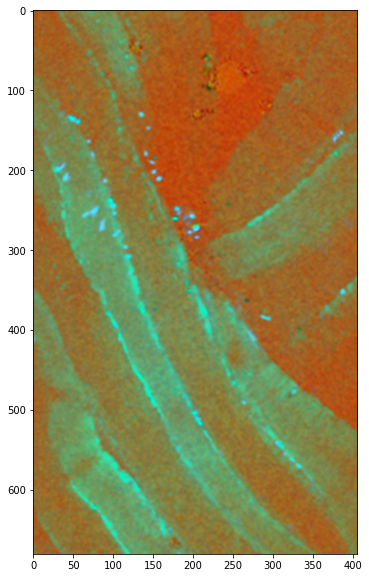

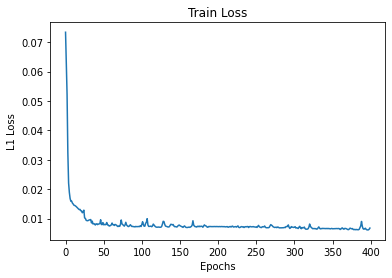

 40%|████████████████                        | 401/1000 [02:06<03:38,  2.75it/s]

Epoch: 401 	Training Loss: 0.006946


 40%|████████████████                        | 402/1000 [02:06<03:27,  2.88it/s]

Epoch: 402 	Training Loss: 0.006512


 40%|████████████████                        | 403/1000 [02:06<03:21,  2.97it/s]

Epoch: 403 	Training Loss: 0.006640


 40%|████████████████▏                       | 404/1000 [02:06<03:16,  3.04it/s]

Epoch: 404 	Training Loss: 0.007226


 40%|████████████████▏                       | 405/1000 [02:07<03:12,  3.09it/s]

Epoch: 405 	Training Loss: 0.006742


 41%|████████████████▏                       | 406/1000 [02:07<03:10,  3.12it/s]

Epoch: 406 	Training Loss: 0.006389


 41%|████████████████▎                       | 407/1000 [02:07<03:08,  3.15it/s]

Epoch: 407 	Training Loss: 0.006281


 41%|████████████████▎                       | 408/1000 [02:08<03:06,  3.17it/s]

Epoch: 408 	Training Loss: 0.006385


 41%|████████████████▎                       | 409/1000 [02:08<03:05,  3.18it/s]

Epoch: 409 	Training Loss: 0.006510


 41%|████████████████▍                       | 410/1000 [02:08<03:04,  3.19it/s]

Epoch: 410 	Training Loss: 0.006368


 41%|████████████████▍                       | 411/1000 [02:09<03:04,  3.20it/s]

Epoch: 411 	Training Loss: 0.006475


 41%|████████████████▍                       | 412/1000 [02:09<03:03,  3.20it/s]

Epoch: 412 	Training Loss: 0.006517


 41%|████████████████▌                       | 413/1000 [02:09<03:03,  3.20it/s]

Epoch: 413 	Training Loss: 0.006395


 41%|████████████████▌                       | 414/1000 [02:10<03:02,  3.21it/s]

Epoch: 414 	Training Loss: 0.006429


 42%|████████████████▌                       | 415/1000 [02:10<03:02,  3.21it/s]

Epoch: 415 	Training Loss: 0.006239


 42%|████████████████▋                       | 416/1000 [02:10<03:01,  3.21it/s]

Epoch: 416 	Training Loss: 0.006153


 42%|████████████████▋                       | 417/1000 [02:11<03:01,  3.21it/s]

Epoch: 417 	Training Loss: 0.006212


 42%|████████████████▋                       | 418/1000 [02:11<03:01,  3.21it/s]

Epoch: 418 	Training Loss: 0.006276


 42%|████████████████▊                       | 419/1000 [02:11<03:00,  3.21it/s]

Epoch: 419 	Training Loss: 0.006188


 42%|████████████████▊                       | 420/1000 [02:11<03:00,  3.21it/s]

Epoch: 420 	Training Loss: 0.006517


 42%|████████████████▊                       | 421/1000 [02:12<03:00,  3.21it/s]

Epoch: 421 	Training Loss: 0.006624


 42%|████████████████▉                       | 422/1000 [02:12<03:00,  3.21it/s]

Epoch: 422 	Training Loss: 0.006521


 42%|████████████████▉                       | 423/1000 [02:12<02:59,  3.21it/s]

Epoch: 423 	Training Loss: 0.006658


 42%|████████████████▉                       | 424/1000 [02:13<02:59,  3.21it/s]

Epoch: 424 	Training Loss: 0.006425


 42%|█████████████████                       | 425/1000 [02:13<02:59,  3.21it/s]

Epoch: 425 	Training Loss: 0.006524


 43%|█████████████████                       | 426/1000 [02:13<02:58,  3.21it/s]

Epoch: 426 	Training Loss: 0.006461


 43%|█████████████████                       | 427/1000 [02:14<02:58,  3.21it/s]

Epoch: 427 	Training Loss: 0.006544


 43%|█████████████████                       | 428/1000 [02:14<02:58,  3.21it/s]

Epoch: 428 	Training Loss: 0.006819


 43%|█████████████████▏                      | 429/1000 [02:14<02:57,  3.21it/s]

Epoch: 429 	Training Loss: 0.006525


 43%|█████████████████▏                      | 430/1000 [02:15<02:57,  3.21it/s]

Epoch: 430 	Training Loss: 0.006353


 43%|█████████████████▏                      | 431/1000 [02:15<02:57,  3.21it/s]

Epoch: 431 	Training Loss: 0.006445


 43%|█████████████████▎                      | 432/1000 [02:15<02:57,  3.21it/s]

Epoch: 432 	Training Loss: 0.006420


 43%|█████████████████▎                      | 433/1000 [02:16<02:56,  3.21it/s]

Epoch: 433 	Training Loss: 0.006444


 43%|█████████████████▎                      | 434/1000 [02:16<02:56,  3.20it/s]

Epoch: 434 	Training Loss: 0.006454


 44%|█████████████████▍                      | 435/1000 [02:16<02:56,  3.21it/s]

Epoch: 435 	Training Loss: 0.006509


 44%|█████████████████▍                      | 436/1000 [02:16<02:55,  3.21it/s]

Epoch: 436 	Training Loss: 0.006319


 44%|█████████████████▍                      | 437/1000 [02:17<02:55,  3.21it/s]

Epoch: 437 	Training Loss: 0.006375


 44%|█████████████████▌                      | 438/1000 [02:17<02:55,  3.21it/s]

Epoch: 438 	Training Loss: 0.006480


 44%|█████████████████▌                      | 439/1000 [02:17<02:54,  3.21it/s]

Epoch: 439 	Training Loss: 0.006392


 44%|█████████████████▌                      | 440/1000 [02:18<02:54,  3.21it/s]

Epoch: 440 	Training Loss: 0.006485


 44%|█████████████████▋                      | 441/1000 [02:18<02:54,  3.21it/s]

Epoch: 441 	Training Loss: 0.006453


 44%|█████████████████▋                      | 442/1000 [02:18<02:54,  3.21it/s]

Epoch: 442 	Training Loss: 0.006452


 44%|█████████████████▋                      | 443/1000 [02:19<02:53,  3.21it/s]

Epoch: 443 	Training Loss: 0.006297


 44%|█████████████████▊                      | 444/1000 [02:19<02:53,  3.21it/s]

Epoch: 444 	Training Loss: 0.006404


 44%|█████████████████▊                      | 445/1000 [02:19<02:53,  3.21it/s]

Epoch: 445 	Training Loss: 0.006598


 45%|█████████████████▊                      | 446/1000 [02:20<02:52,  3.21it/s]

Epoch: 446 	Training Loss: 0.006403


 45%|█████████████████▉                      | 447/1000 [02:20<02:52,  3.21it/s]

Epoch: 447 	Training Loss: 0.006451


 45%|█████████████████▉                      | 448/1000 [02:20<02:51,  3.21it/s]

Epoch: 448 	Training Loss: 0.006406


 45%|█████████████████▉                      | 449/1000 [02:20<02:51,  3.21it/s]

Epoch: 449 	Training Loss: 0.006478
Epoch: 450 	Training Loss: 0.006414


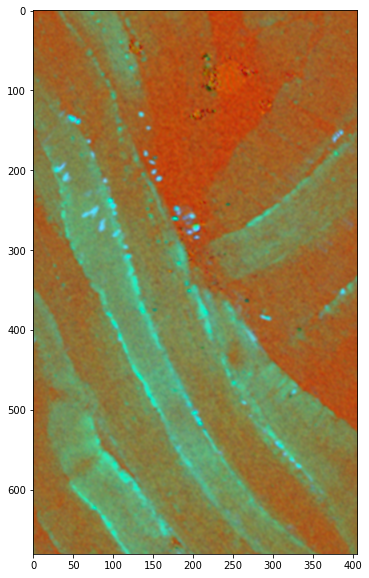

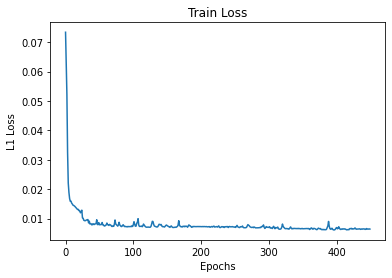

 45%|██████████████████                      | 451/1000 [02:21<03:19,  2.76it/s]

Epoch: 451 	Training Loss: 0.006414


 45%|██████████████████                      | 452/1000 [02:22<03:10,  2.88it/s]

Epoch: 452 	Training Loss: 0.006223


 45%|██████████████████                      | 453/1000 [02:22<03:04,  2.97it/s]

Epoch: 453 	Training Loss: 0.006220


 45%|██████████████████▏                     | 454/1000 [02:22<02:59,  3.04it/s]

Epoch: 454 	Training Loss: 0.006315


 46%|██████████████████▏                     | 455/1000 [02:23<02:56,  3.09it/s]

Epoch: 455 	Training Loss: 0.006530


 46%|██████████████████▏                     | 456/1000 [02:23<02:53,  3.13it/s]

Epoch: 456 	Training Loss: 0.006470


 46%|██████████████████▎                     | 457/1000 [02:23<02:52,  3.15it/s]

Epoch: 457 	Training Loss: 0.006454


 46%|██████████████████▎                     | 458/1000 [02:24<02:51,  3.17it/s]

Epoch: 458 	Training Loss: 0.006376


 46%|██████████████████▎                     | 459/1000 [02:24<02:50,  3.18it/s]

Epoch: 459 	Training Loss: 0.006518


 46%|██████████████████▍                     | 460/1000 [02:24<02:49,  3.18it/s]

Epoch: 460 	Training Loss: 0.006328


 46%|██████████████████▍                     | 461/1000 [02:24<02:48,  3.19it/s]

Epoch: 461 	Training Loss: 0.006492


 46%|██████████████████▍                     | 462/1000 [02:25<02:48,  3.20it/s]

Epoch: 462 	Training Loss: 0.006396


 46%|██████████████████▌                     | 463/1000 [02:25<02:48,  3.20it/s]

Epoch: 463 	Training Loss: 0.006394


 46%|██████████████████▌                     | 464/1000 [02:25<02:47,  3.20it/s]

Epoch: 464 	Training Loss: 0.006457


 46%|██████████████████▌                     | 465/1000 [02:26<02:46,  3.21it/s]

Epoch: 465 	Training Loss: 0.006387


 47%|██████████████████▋                     | 466/1000 [02:26<02:46,  3.20it/s]

Epoch: 466 	Training Loss: 0.006448


 47%|██████████████████▋                     | 467/1000 [02:26<02:46,  3.20it/s]

Epoch: 467 	Training Loss: 0.006404


 47%|██████████████████▋                     | 468/1000 [02:27<02:45,  3.21it/s]

Epoch: 468 	Training Loss: 0.006318


 47%|██████████████████▊                     | 469/1000 [02:27<02:45,  3.21it/s]

Epoch: 469 	Training Loss: 0.006120


 47%|██████████████████▊                     | 470/1000 [02:27<02:45,  3.20it/s]

Epoch: 470 	Training Loss: 0.006208


 47%|██████████████████▊                     | 471/1000 [02:28<02:45,  3.20it/s]

Epoch: 471 	Training Loss: 0.006497


 47%|██████████████████▉                     | 472/1000 [02:28<02:44,  3.21it/s]

Epoch: 472 	Training Loss: 0.006479


 47%|██████████████████▉                     | 473/1000 [02:28<02:44,  3.21it/s]

Epoch: 473 	Training Loss: 0.006431


 47%|██████████████████▉                     | 474/1000 [02:29<02:44,  3.21it/s]

Epoch: 474 	Training Loss: 0.006435


 48%|███████████████████                     | 475/1000 [02:29<02:43,  3.20it/s]

Epoch: 475 	Training Loss: 0.006384


 48%|███████████████████                     | 476/1000 [02:29<02:43,  3.20it/s]

Epoch: 476 	Training Loss: 0.006329


 48%|███████████████████                     | 477/1000 [02:29<02:43,  3.20it/s]

Epoch: 477 	Training Loss: 0.006381


 48%|███████████████████                     | 478/1000 [02:30<02:42,  3.20it/s]

Epoch: 478 	Training Loss: 0.006420


 48%|███████████████████▏                    | 479/1000 [02:30<02:42,  3.20it/s]

Epoch: 479 	Training Loss: 0.006344


 48%|███████████████████▏                    | 480/1000 [02:30<02:42,  3.20it/s]

Epoch: 480 	Training Loss: 0.006150


 48%|███████████████████▏                    | 481/1000 [02:31<02:41,  3.20it/s]

Epoch: 481 	Training Loss: 0.006194


 48%|███████████████████▎                    | 482/1000 [02:31<02:41,  3.20it/s]

Epoch: 482 	Training Loss: 0.006145


 48%|███████████████████▎                    | 483/1000 [02:31<02:41,  3.20it/s]

Epoch: 483 	Training Loss: 0.006148


 48%|███████████████████▎                    | 484/1000 [02:32<02:41,  3.19it/s]

Epoch: 484 	Training Loss: 0.006403


 48%|███████████████████▍                    | 485/1000 [02:32<02:40,  3.20it/s]

Epoch: 485 	Training Loss: 0.006662


 49%|███████████████████▍                    | 486/1000 [02:32<02:40,  3.20it/s]

Epoch: 486 	Training Loss: 0.006402


 49%|███████████████████▍                    | 487/1000 [02:33<02:40,  3.20it/s]

Epoch: 487 	Training Loss: 0.006447


 49%|███████████████████▌                    | 488/1000 [02:33<02:39,  3.20it/s]

Epoch: 488 	Training Loss: 0.006434


 49%|███████████████████▌                    | 489/1000 [02:33<02:39,  3.20it/s]

Epoch: 489 	Training Loss: 0.006345


 49%|███████████████████▌                    | 490/1000 [02:34<02:39,  3.20it/s]

Epoch: 490 	Training Loss: 0.006097


 49%|███████████████████▋                    | 491/1000 [02:34<02:39,  3.20it/s]

Epoch: 491 	Training Loss: 0.006311


 49%|███████████████████▋                    | 492/1000 [02:34<02:38,  3.20it/s]

Epoch: 492 	Training Loss: 0.006484


 49%|███████████████████▋                    | 493/1000 [02:34<02:38,  3.20it/s]

Epoch: 493 	Training Loss: 0.006494


 49%|███████████████████▊                    | 494/1000 [02:35<02:38,  3.20it/s]

Epoch: 494 	Training Loss: 0.006421


 50%|███████████████████▊                    | 495/1000 [02:35<02:37,  3.20it/s]

Epoch: 495 	Training Loss: 0.006361


 50%|███████████████████▊                    | 496/1000 [02:35<02:37,  3.20it/s]

Epoch: 496 	Training Loss: 0.006457


 50%|███████████████████▉                    | 497/1000 [02:36<02:37,  3.20it/s]

Epoch: 497 	Training Loss: 0.006138


 50%|███████████████████▉                    | 498/1000 [02:36<02:36,  3.20it/s]

Epoch: 498 	Training Loss: 0.006174


 50%|███████████████████▉                    | 499/1000 [02:36<02:36,  3.20it/s]

Epoch: 499 	Training Loss: 0.006326
Epoch: 500 	Training Loss: 0.006481


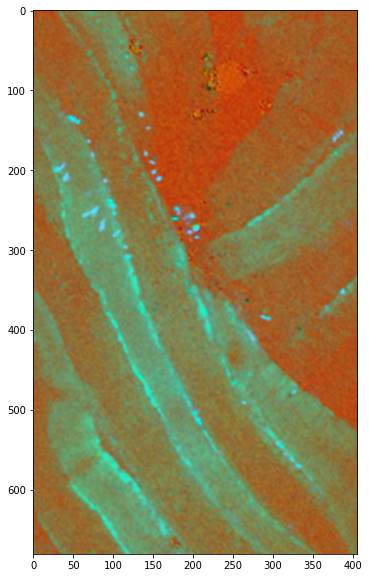

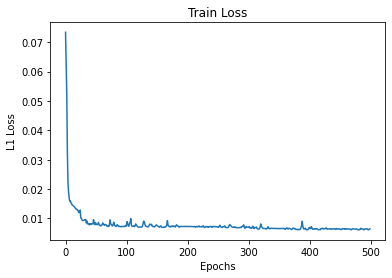

 50%|████████████████████                    | 501/1000 [02:37<03:01,  2.75it/s]

Epoch: 501 	Training Loss: 0.006515


 50%|████████████████████                    | 502/1000 [02:38<02:53,  2.87it/s]

Epoch: 502 	Training Loss: 0.006457


 50%|████████████████████                    | 503/1000 [02:38<02:47,  2.96it/s]

Epoch: 503 	Training Loss: 0.006455


 50%|████████████████████▏                   | 504/1000 [02:38<02:43,  3.03it/s]

Epoch: 504 	Training Loss: 0.006371


 50%|████████████████████▏                   | 505/1000 [02:38<02:40,  3.08it/s]

Epoch: 505 	Training Loss: 0.006388


 51%|████████████████████▏                   | 506/1000 [02:39<02:38,  3.12it/s]

Epoch: 506 	Training Loss: 0.006494


 51%|████████████████████▎                   | 507/1000 [02:39<02:36,  3.14it/s]

Epoch: 507 	Training Loss: 0.006281


 51%|████████████████████▎                   | 508/1000 [02:39<02:35,  3.16it/s]

Epoch: 508 	Training Loss: 0.006414


 51%|████████████████████▎                   | 509/1000 [02:40<02:34,  3.17it/s]

Epoch: 509 	Training Loss: 0.006448


 51%|████████████████████▍                   | 510/1000 [02:40<02:34,  3.18it/s]

Epoch: 510 	Training Loss: 0.006457


 51%|████████████████████▍                   | 511/1000 [02:40<02:33,  3.18it/s]

Epoch: 511 	Training Loss: 0.006276


 51%|████████████████████▍                   | 512/1000 [02:41<02:32,  3.19it/s]

Epoch: 512 	Training Loss: 0.006128


 51%|████████████████████▌                   | 513/1000 [02:41<02:32,  3.20it/s]

Epoch: 513 	Training Loss: 0.006118


 51%|████████████████████▌                   | 514/1000 [02:41<02:32,  3.20it/s]

Epoch: 514 	Training Loss: 0.006294


 52%|████████████████████▌                   | 515/1000 [02:42<02:31,  3.20it/s]

Epoch: 515 	Training Loss: 0.006532


 52%|████████████████████▋                   | 516/1000 [02:42<02:31,  3.20it/s]

Epoch: 516 	Training Loss: 0.006430


 52%|████████████████████▋                   | 517/1000 [02:42<02:31,  3.20it/s]

Epoch: 517 	Training Loss: 0.006463


 52%|████████████████████▋                   | 518/1000 [02:43<02:30,  3.20it/s]

Epoch: 518 	Training Loss: 0.006514


 52%|████████████████████▊                   | 519/1000 [02:43<02:30,  3.19it/s]

Epoch: 519 	Training Loss: 0.006299


 52%|████████████████████▊                   | 520/1000 [02:43<02:30,  3.20it/s]

Epoch: 520 	Training Loss: 0.006207


 52%|████████████████████▊                   | 521/1000 [02:43<02:29,  3.20it/s]

Epoch: 521 	Training Loss: 0.006432


 52%|████████████████████▉                   | 522/1000 [02:44<02:29,  3.20it/s]

Epoch: 522 	Training Loss: 0.006377


 52%|████████████████████▉                   | 523/1000 [02:44<02:29,  3.20it/s]

Epoch: 523 	Training Loss: 0.006100


 52%|████████████████████▉                   | 524/1000 [02:44<02:29,  3.19it/s]

Epoch: 524 	Training Loss: 0.006072


 52%|█████████████████████                   | 525/1000 [02:45<02:28,  3.19it/s]

Epoch: 525 	Training Loss: 0.006110


 53%|█████████████████████                   | 526/1000 [02:45<02:28,  3.20it/s]

Epoch: 526 	Training Loss: 0.006059


 53%|█████████████████████                   | 527/1000 [02:45<02:27,  3.20it/s]

Epoch: 527 	Training Loss: 0.006311


 53%|█████████████████████                   | 528/1000 [02:46<02:27,  3.20it/s]

Epoch: 528 	Training Loss: 0.006584


 53%|█████████████████████▏                  | 529/1000 [02:46<02:27,  3.20it/s]

Epoch: 529 	Training Loss: 0.006203


 53%|█████████████████████▏                  | 530/1000 [02:46<02:27,  3.19it/s]

Epoch: 530 	Training Loss: 0.006026


 53%|█████████████████████▏                  | 531/1000 [02:47<02:26,  3.20it/s]

Epoch: 531 	Training Loss: 0.006156


 53%|█████████████████████▎                  | 532/1000 [02:47<02:26,  3.20it/s]

Epoch: 532 	Training Loss: 0.006135


 53%|█████████████████████▎                  | 533/1000 [02:47<02:25,  3.20it/s]

Epoch: 533 	Training Loss: 0.006115


 53%|█████████████████████▎                  | 534/1000 [02:48<02:25,  3.20it/s]

Epoch: 534 	Training Loss: 0.006428


 54%|█████████████████████▍                  | 535/1000 [02:48<02:25,  3.19it/s]

Epoch: 535 	Training Loss: 0.006627


 54%|█████████████████████▍                  | 536/1000 [02:48<02:25,  3.19it/s]

Epoch: 536 	Training Loss: 0.006578


 54%|█████████████████████▍                  | 537/1000 [02:48<02:25,  3.19it/s]

Epoch: 537 	Training Loss: 0.007010


 54%|█████████████████████▌                  | 538/1000 [02:49<02:24,  3.19it/s]

Epoch: 538 	Training Loss: 0.007629


 54%|█████████████████████▌                  | 539/1000 [02:49<02:24,  3.20it/s]

Epoch: 539 	Training Loss: 0.006403


 54%|█████████████████████▌                  | 540/1000 [02:49<02:23,  3.20it/s]

Epoch: 540 	Training Loss: 0.006177


 54%|█████████████████████▋                  | 541/1000 [02:50<02:23,  3.20it/s]

Epoch: 541 	Training Loss: 0.006303


 54%|█████████████████████▋                  | 542/1000 [02:50<02:23,  3.20it/s]

Epoch: 542 	Training Loss: 0.006338


 54%|█████████████████████▋                  | 543/1000 [02:50<02:22,  3.20it/s]

Epoch: 543 	Training Loss: 0.006422


 54%|█████████████████████▊                  | 544/1000 [02:51<02:22,  3.20it/s]

Epoch: 544 	Training Loss: 0.006383


 55%|█████████████████████▊                  | 545/1000 [02:51<02:22,  3.20it/s]

Epoch: 545 	Training Loss: 0.006326


 55%|█████████████████████▊                  | 546/1000 [02:51<02:21,  3.20it/s]

Epoch: 546 	Training Loss: 0.006271


 55%|█████████████████████▉                  | 547/1000 [02:52<02:21,  3.20it/s]

Epoch: 547 	Training Loss: 0.006213


 55%|█████████████████████▉                  | 548/1000 [02:52<02:21,  3.19it/s]

Epoch: 548 	Training Loss: 0.006238


 55%|█████████████████████▉                  | 549/1000 [02:52<02:21,  3.19it/s]

Epoch: 549 	Training Loss: 0.006243
Epoch: 550 	Training Loss: 0.006255


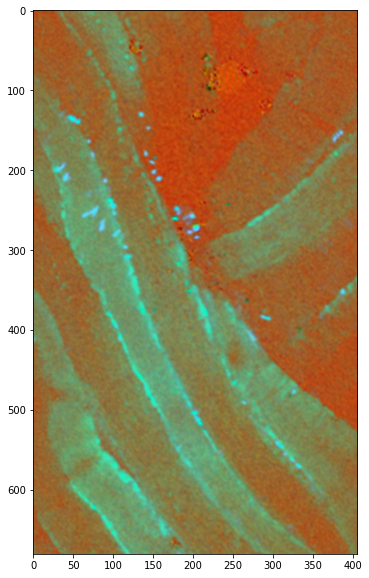

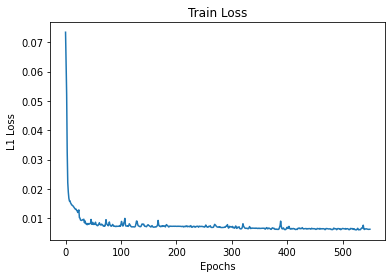

 55%|██████████████████████                  | 551/1000 [02:53<02:43,  2.74it/s]

Epoch: 551 	Training Loss: 0.006046


 55%|██████████████████████                  | 552/1000 [02:53<02:36,  2.87it/s]

Epoch: 552 	Training Loss: 0.006133


 55%|██████████████████████                  | 553/1000 [02:54<02:31,  2.96it/s]

Epoch: 553 	Training Loss: 0.006091


 55%|██████████████████████▏                 | 554/1000 [02:54<02:27,  3.03it/s]

Epoch: 554 	Training Loss: 0.006401


 56%|██████████████████████▏                 | 555/1000 [02:54<02:24,  3.08it/s]

Epoch: 555 	Training Loss: 0.006776


 56%|██████████████████████▏                 | 556/1000 [02:55<02:22,  3.11it/s]

Epoch: 556 	Training Loss: 0.006385


 56%|██████████████████████▎                 | 557/1000 [02:55<02:21,  3.14it/s]

Epoch: 557 	Training Loss: 0.006258


 56%|██████████████████████▎                 | 558/1000 [02:55<02:19,  3.16it/s]

Epoch: 558 	Training Loss: 0.006342


 56%|██████████████████████▎                 | 559/1000 [02:56<02:19,  3.17it/s]

Epoch: 559 	Training Loss: 0.006457


 56%|██████████████████████▍                 | 560/1000 [02:56<02:18,  3.18it/s]

Epoch: 560 	Training Loss: 0.006605


 56%|██████████████████████▍                 | 561/1000 [02:56<02:17,  3.19it/s]

Epoch: 561 	Training Loss: 0.006261


 56%|██████████████████████▍                 | 562/1000 [02:57<02:17,  3.19it/s]

Epoch: 562 	Training Loss: 0.006143


 56%|██████████████████████▌                 | 563/1000 [02:57<02:16,  3.19it/s]

Epoch: 563 	Training Loss: 0.006093


 56%|██████████████████████▌                 | 564/1000 [02:57<02:16,  3.20it/s]

Epoch: 564 	Training Loss: 0.006163


 56%|██████████████████████▌                 | 565/1000 [02:57<02:16,  3.20it/s]

Epoch: 565 	Training Loss: 0.006338


 57%|██████████████████████▋                 | 566/1000 [02:58<02:15,  3.19it/s]

Epoch: 566 	Training Loss: 0.006463


 57%|██████████████████████▋                 | 567/1000 [02:58<02:15,  3.19it/s]

Epoch: 567 	Training Loss: 0.006352


 57%|██████████████████████▋                 | 568/1000 [02:58<02:15,  3.19it/s]

Epoch: 568 	Training Loss: 0.006330


 57%|██████████████████████▊                 | 569/1000 [02:59<02:14,  3.20it/s]

Epoch: 569 	Training Loss: 0.006251


 57%|██████████████████████▊                 | 570/1000 [02:59<02:14,  3.20it/s]

Epoch: 570 	Training Loss: 0.006193


 57%|██████████████████████▊                 | 571/1000 [02:59<02:14,  3.20it/s]

Epoch: 571 	Training Loss: 0.006104


 57%|██████████████████████▉                 | 572/1000 [03:00<02:13,  3.20it/s]

Epoch: 572 	Training Loss: 0.006111


 57%|██████████████████████▉                 | 573/1000 [03:00<02:13,  3.19it/s]

Epoch: 573 	Training Loss: 0.006057


 57%|██████████████████████▉                 | 574/1000 [03:00<02:13,  3.19it/s]

Epoch: 574 	Training Loss: 0.006326


 57%|███████████████████████                 | 575/1000 [03:01<02:12,  3.20it/s]

Epoch: 575 	Training Loss: 0.006480


 58%|███████████████████████                 | 576/1000 [03:01<02:12,  3.20it/s]

Epoch: 576 	Training Loss: 0.006363


 58%|███████████████████████                 | 577/1000 [03:01<02:12,  3.19it/s]

Epoch: 577 	Training Loss: 0.006388


 58%|███████████████████████                 | 578/1000 [03:02<02:12,  3.19it/s]

Epoch: 578 	Training Loss: 0.006350


 58%|███████████████████████▏                | 579/1000 [03:02<02:11,  3.20it/s]

Epoch: 579 	Training Loss: 0.006257


 58%|███████████████████████▏                | 580/1000 [03:02<02:11,  3.20it/s]

Epoch: 580 	Training Loss: 0.006070


 58%|███████████████████████▏                | 581/1000 [03:02<02:11,  3.20it/s]

Epoch: 581 	Training Loss: 0.006396


 58%|███████████████████████▎                | 582/1000 [03:03<02:10,  3.19it/s]

Epoch: 582 	Training Loss: 0.006514


 58%|███████████████████████▎                | 583/1000 [03:03<02:10,  3.20it/s]

Epoch: 583 	Training Loss: 0.006344


 58%|███████████████████████▎                | 584/1000 [03:03<02:10,  3.20it/s]

Epoch: 584 	Training Loss: 0.006364


 58%|███████████████████████▍                | 585/1000 [03:04<02:09,  3.19it/s]

Epoch: 585 	Training Loss: 0.006260


 59%|███████████████████████▍                | 586/1000 [03:04<02:09,  3.19it/s]

Epoch: 586 	Training Loss: 0.006459


 59%|███████████████████████▍                | 587/1000 [03:04<02:09,  3.19it/s]

Epoch: 587 	Training Loss: 0.006515


 59%|███████████████████████▌                | 588/1000 [03:05<02:09,  3.19it/s]

Epoch: 588 	Training Loss: 0.006251


 59%|███████████████████████▌                | 589/1000 [03:05<02:08,  3.19it/s]

Epoch: 589 	Training Loss: 0.006238


 59%|███████████████████████▌                | 590/1000 [03:05<02:08,  3.20it/s]

Epoch: 590 	Training Loss: 0.006034


 59%|███████████████████████▋                | 591/1000 [03:06<02:08,  3.19it/s]

Epoch: 591 	Training Loss: 0.006211


 59%|███████████████████████▋                | 592/1000 [03:06<02:07,  3.19it/s]

Epoch: 592 	Training Loss: 0.006300


 59%|███████████████████████▋                | 593/1000 [03:06<02:07,  3.19it/s]

Epoch: 593 	Training Loss: 0.006152


 59%|███████████████████████▊                | 594/1000 [03:07<02:06,  3.20it/s]

Epoch: 594 	Training Loss: 0.006138


 60%|███████████████████████▊                | 595/1000 [03:07<02:06,  3.20it/s]

Epoch: 595 	Training Loss: 0.006066


 60%|███████████████████████▊                | 596/1000 [03:07<02:06,  3.20it/s]

Epoch: 596 	Training Loss: 0.006461


 60%|███████████████████████▉                | 597/1000 [03:07<02:06,  3.19it/s]

Epoch: 597 	Training Loss: 0.006921


 60%|███████████████████████▉                | 598/1000 [03:08<02:06,  3.19it/s]

Epoch: 598 	Training Loss: 0.006567


 60%|███████████████████████▉                | 599/1000 [03:08<02:05,  3.19it/s]

Epoch: 599 	Training Loss: 0.006332
Epoch: 600 	Training Loss: 0.006278


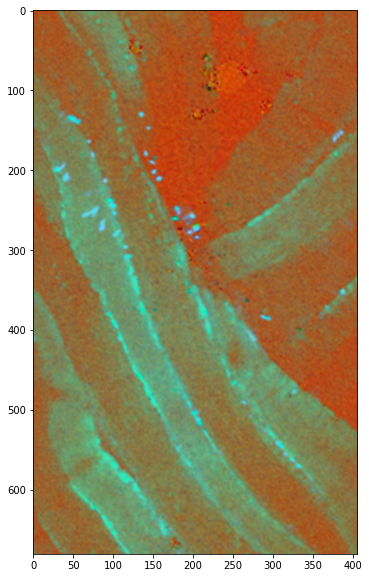

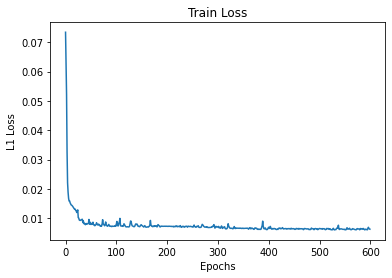

 60%|████████████████████████                | 601/1000 [03:09<02:26,  2.73it/s]

Epoch: 601 	Training Loss: 0.006295


 60%|████████████████████████                | 602/1000 [03:09<02:19,  2.86it/s]

Epoch: 602 	Training Loss: 0.006325


 60%|████████████████████████                | 603/1000 [03:10<02:14,  2.96it/s]

Epoch: 603 	Training Loss: 0.006185


 60%|████████████████████████▏               | 604/1000 [03:10<02:10,  3.02it/s]

Epoch: 604 	Training Loss: 0.006236


 60%|████████████████████████▏               | 605/1000 [03:10<02:08,  3.07it/s]

Epoch: 605 	Training Loss: 0.006078


 61%|████████████████████████▏               | 606/1000 [03:11<02:06,  3.11it/s]

Epoch: 606 	Training Loss: 0.006098


 61%|████████████████████████▎               | 607/1000 [03:11<02:05,  3.14it/s]

Epoch: 607 	Training Loss: 0.006084


 61%|████████████████████████▎               | 608/1000 [03:11<02:04,  3.16it/s]

Epoch: 608 	Training Loss: 0.006320


 61%|████████████████████████▎               | 609/1000 [03:12<02:03,  3.17it/s]

Epoch: 609 	Training Loss: 0.006482


 61%|████████████████████████▍               | 610/1000 [03:12<02:02,  3.17it/s]

Epoch: 610 	Training Loss: 0.006362


 61%|████████████████████████▍               | 611/1000 [03:12<02:02,  3.18it/s]

Epoch: 611 	Training Loss: 0.006365


 61%|████████████████████████▍               | 612/1000 [03:12<02:01,  3.18it/s]

Epoch: 612 	Training Loss: 0.006305


 61%|████████████████████████▌               | 613/1000 [03:13<02:01,  3.18it/s]

Epoch: 613 	Training Loss: 0.006252


 61%|████████████████████████▌               | 614/1000 [03:13<02:01,  3.18it/s]

Epoch: 614 	Training Loss: 0.006200


 62%|████████████████████████▌               | 615/1000 [03:13<02:00,  3.19it/s]

Epoch: 615 	Training Loss: 0.006409


 62%|████████████████████████▋               | 616/1000 [03:14<02:00,  3.18it/s]

Epoch: 616 	Training Loss: 0.006292


 62%|████████████████████████▋               | 617/1000 [03:14<02:00,  3.19it/s]

Epoch: 617 	Training Loss: 0.006208


 62%|████████████████████████▋               | 618/1000 [03:14<01:59,  3.19it/s]

Epoch: 618 	Training Loss: 0.006265


 62%|████████████████████████▊               | 619/1000 [03:15<01:59,  3.19it/s]

Epoch: 619 	Training Loss: 0.006280


 62%|████████████████████████▊               | 620/1000 [03:15<01:59,  3.19it/s]

Epoch: 620 	Training Loss: 0.006214


 62%|████████████████████████▊               | 621/1000 [03:15<01:58,  3.19it/s]

Epoch: 621 	Training Loss: 0.006319


 62%|████████████████████████▉               | 622/1000 [03:16<01:58,  3.19it/s]

Epoch: 622 	Training Loss: 0.006403


 62%|████████████████████████▉               | 623/1000 [03:16<01:58,  3.19it/s]

Epoch: 623 	Training Loss: 0.006250


 62%|████████████████████████▉               | 624/1000 [03:16<01:57,  3.20it/s]

Epoch: 624 	Training Loss: 0.006179


 62%|█████████████████████████               | 625/1000 [03:17<01:57,  3.19it/s]

Epoch: 625 	Training Loss: 0.006271


 63%|█████████████████████████               | 626/1000 [03:17<01:57,  3.19it/s]

Epoch: 626 	Training Loss: 0.006260


 63%|█████████████████████████               | 627/1000 [03:17<01:57,  3.19it/s]

Epoch: 627 	Training Loss: 0.006064


 63%|█████████████████████████               | 628/1000 [03:17<01:56,  3.19it/s]

Epoch: 628 	Training Loss: 0.006129


 63%|█████████████████████████▏              | 629/1000 [03:18<01:56,  3.18it/s]

Epoch: 629 	Training Loss: 0.006108


 63%|█████████████████████████▏              | 630/1000 [03:18<01:56,  3.18it/s]

Epoch: 630 	Training Loss: 0.006342


 63%|█████████████████████████▏              | 631/1000 [03:18<01:55,  3.18it/s]

Epoch: 631 	Training Loss: 0.006466


 63%|█████████████████████████▎              | 632/1000 [03:19<01:55,  3.19it/s]

Epoch: 632 	Training Loss: 0.006362


 63%|█████████████████████████▎              | 633/1000 [03:19<01:54,  3.19it/s]

Epoch: 633 	Training Loss: 0.006309


 63%|█████████████████████████▎              | 634/1000 [03:19<01:54,  3.20it/s]

Epoch: 634 	Training Loss: 0.006361


 64%|█████████████████████████▍              | 635/1000 [03:20<01:54,  3.19it/s]

Epoch: 635 	Training Loss: 0.006291


 64%|█████████████████████████▍              | 636/1000 [03:20<01:54,  3.19it/s]

Epoch: 636 	Training Loss: 0.006307


 64%|█████████████████████████▍              | 637/1000 [03:20<01:53,  3.19it/s]

Epoch: 637 	Training Loss: 0.006287


 64%|█████████████████████████▌              | 638/1000 [03:21<01:53,  3.20it/s]

Epoch: 638 	Training Loss: 0.006417


 64%|█████████████████████████▌              | 639/1000 [03:21<01:52,  3.20it/s]

Epoch: 639 	Training Loss: 0.006837


 64%|█████████████████████████▌              | 640/1000 [03:21<01:52,  3.20it/s]

Epoch: 640 	Training Loss: 0.006798


 64%|█████████████████████████▋              | 641/1000 [03:22<01:52,  3.20it/s]

Epoch: 641 	Training Loss: 0.006342


 64%|█████████████████████████▋              | 642/1000 [03:22<01:51,  3.20it/s]

Epoch: 642 	Training Loss: 0.006216


 64%|█████████████████████████▋              | 643/1000 [03:22<01:51,  3.20it/s]

Epoch: 643 	Training Loss: 0.006238


 64%|█████████████████████████▊              | 644/1000 [03:22<01:51,  3.19it/s]

Epoch: 644 	Training Loss: 0.006146


 64%|█████████████████████████▊              | 645/1000 [03:23<01:51,  3.19it/s]

Epoch: 645 	Training Loss: 0.005972


 65%|█████████████████████████▊              | 646/1000 [03:23<01:51,  3.19it/s]

Epoch: 646 	Training Loss: 0.006206


 65%|█████████████████████████▉              | 647/1000 [03:23<01:50,  3.19it/s]

Epoch: 647 	Training Loss: 0.006377


 65%|█████████████████████████▉              | 648/1000 [03:24<01:50,  3.19it/s]

Epoch: 648 	Training Loss: 0.006345


 65%|█████████████████████████▉              | 649/1000 [03:24<01:50,  3.19it/s]

Epoch: 649 	Training Loss: 0.006256
Epoch: 650 	Training Loss: 0.006303


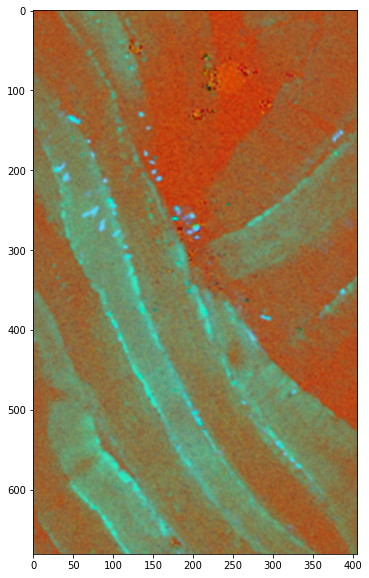

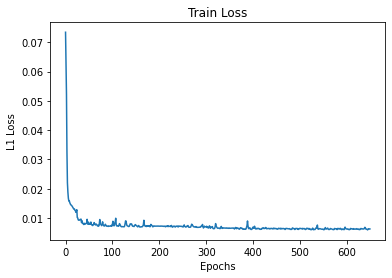

 65%|██████████████████████████              | 651/1000 [03:25<02:12,  2.64it/s]

Epoch: 651 	Training Loss: 0.006119


 65%|██████████████████████████              | 652/1000 [03:25<02:04,  2.79it/s]

Epoch: 652 	Training Loss: 0.006023


 65%|██████████████████████████              | 653/1000 [03:26<01:59,  2.90it/s]

Epoch: 653 	Training Loss: 0.006026


 65%|██████████████████████████▏             | 654/1000 [03:26<01:56,  2.98it/s]

Epoch: 654 	Training Loss: 0.005988


 66%|██████████████████████████▏             | 655/1000 [03:26<01:53,  3.05it/s]

Epoch: 655 	Training Loss: 0.005993


 66%|██████████████████████████▏             | 656/1000 [03:27<01:51,  3.09it/s]

Epoch: 656 	Training Loss: 0.006391


 66%|██████████████████████████▎             | 657/1000 [03:27<01:49,  3.12it/s]

Epoch: 657 	Training Loss: 0.006319


 66%|██████████████████████████▎             | 658/1000 [03:27<01:48,  3.14it/s]

Epoch: 658 	Training Loss: 0.006305


 66%|██████████████████████████▎             | 659/1000 [03:27<01:48,  3.15it/s]

Epoch: 659 	Training Loss: 0.006307


 66%|██████████████████████████▍             | 660/1000 [03:28<01:47,  3.16it/s]

Epoch: 660 	Training Loss: 0.006183


 66%|██████████████████████████▍             | 661/1000 [03:28<01:46,  3.17it/s]

Epoch: 661 	Training Loss: 0.006123


 66%|██████████████████████████▍             | 662/1000 [03:28<01:46,  3.17it/s]

Epoch: 662 	Training Loss: 0.006205


 66%|██████████████████████████▌             | 663/1000 [03:29<01:46,  3.18it/s]

Epoch: 663 	Training Loss: 0.006327


 66%|██████████████████████████▌             | 664/1000 [03:29<01:45,  3.18it/s]

Epoch: 664 	Training Loss: 0.006362


 66%|██████████████████████████▌             | 665/1000 [03:29<01:45,  3.18it/s]

Epoch: 665 	Training Loss: 0.006176


 67%|██████████████████████████▋             | 666/1000 [03:30<01:44,  3.18it/s]

Epoch: 666 	Training Loss: 0.006271


 67%|██████████████████████████▋             | 667/1000 [03:30<01:44,  3.18it/s]

Epoch: 667 	Training Loss: 0.006007


 67%|██████████████████████████▋             | 668/1000 [03:30<01:44,  3.18it/s]

Epoch: 668 	Training Loss: 0.006315


 67%|██████████████████████████▊             | 669/1000 [03:31<01:43,  3.18it/s]

Epoch: 669 	Training Loss: 0.006372


 67%|██████████████████████████▊             | 670/1000 [03:31<01:43,  3.18it/s]

Epoch: 670 	Training Loss: 0.006229


 67%|██████████████████████████▊             | 671/1000 [03:31<01:43,  3.18it/s]

Epoch: 671 	Training Loss: 0.006283


 67%|██████████████████████████▉             | 672/1000 [03:32<01:43,  3.18it/s]

Epoch: 672 	Training Loss: 0.006210


 67%|██████████████████████████▉             | 673/1000 [03:32<01:42,  3.18it/s]

Epoch: 673 	Training Loss: 0.006316


 67%|██████████████████████████▉             | 674/1000 [03:32<01:42,  3.18it/s]

Epoch: 674 	Training Loss: 0.006240


 68%|███████████████████████████             | 675/1000 [03:33<01:42,  3.18it/s]

Epoch: 675 	Training Loss: 0.006117


 68%|███████████████████████████             | 676/1000 [03:33<01:41,  3.19it/s]

Epoch: 676 	Training Loss: 0.006335


 68%|███████████████████████████             | 677/1000 [03:33<01:41,  3.19it/s]

Epoch: 677 	Training Loss: 0.006362


 68%|███████████████████████████             | 678/1000 [03:33<01:41,  3.19it/s]

Epoch: 678 	Training Loss: 0.006262


 68%|███████████████████████████▏            | 679/1000 [03:34<01:40,  3.19it/s]

Epoch: 679 	Training Loss: 0.006265


 68%|███████████████████████████▏            | 680/1000 [03:34<01:40,  3.19it/s]

Epoch: 680 	Training Loss: 0.006216


 68%|███████████████████████████▏            | 681/1000 [03:34<01:40,  3.19it/s]

Epoch: 681 	Training Loss: 0.006048


 68%|███████████████████████████▎            | 682/1000 [03:35<01:39,  3.19it/s]

Epoch: 682 	Training Loss: 0.006001


 68%|███████████████████████████▎            | 683/1000 [03:35<01:39,  3.18it/s]

Epoch: 683 	Training Loss: 0.006239


 68%|███████████████████████████▎            | 684/1000 [03:35<01:38,  3.19it/s]

Epoch: 684 	Training Loss: 0.006508


 68%|███████████████████████████▍            | 685/1000 [03:36<01:38,  3.19it/s]

Epoch: 685 	Training Loss: 0.006147


 69%|███████████████████████████▍            | 686/1000 [03:36<01:38,  3.19it/s]

Epoch: 686 	Training Loss: 0.005958


 69%|███████████████████████████▍            | 687/1000 [03:36<01:38,  3.19it/s]

Epoch: 687 	Training Loss: 0.006366


 69%|███████████████████████████▌            | 688/1000 [03:37<01:37,  3.19it/s]

Epoch: 688 	Training Loss: 0.006898


 69%|███████████████████████████▌            | 689/1000 [03:37<01:37,  3.19it/s]

Epoch: 689 	Training Loss: 0.007357


 69%|███████████████████████████▌            | 690/1000 [03:37<01:37,  3.19it/s]

Epoch: 690 	Training Loss: 0.006308


 69%|███████████████████████████▋            | 691/1000 [03:38<01:37,  3.18it/s]

Epoch: 691 	Training Loss: 0.006287


 69%|███████████████████████████▋            | 692/1000 [03:38<01:36,  3.19it/s]

Epoch: 692 	Training Loss: 0.006640


 69%|███████████████████████████▋            | 693/1000 [03:38<01:36,  3.19it/s]

Epoch: 693 	Training Loss: 0.006443


 69%|███████████████████████████▊            | 694/1000 [03:38<01:36,  3.19it/s]

Epoch: 694 	Training Loss: 0.006090


 70%|███████████████████████████▊            | 695/1000 [03:39<01:35,  3.19it/s]

Epoch: 695 	Training Loss: 0.006046


 70%|███████████████████████████▊            | 696/1000 [03:39<01:35,  3.19it/s]

Epoch: 696 	Training Loss: 0.006309


 70%|███████████████████████████▉            | 697/1000 [03:39<01:35,  3.18it/s]

Epoch: 697 	Training Loss: 0.006303


 70%|███████████████████████████▉            | 698/1000 [03:40<01:34,  3.18it/s]

Epoch: 698 	Training Loss: 0.006129


 70%|███████████████████████████▉            | 699/1000 [03:40<01:34,  3.18it/s]

Epoch: 699 	Training Loss: 0.006050
Epoch: 700 	Training Loss: 0.005981


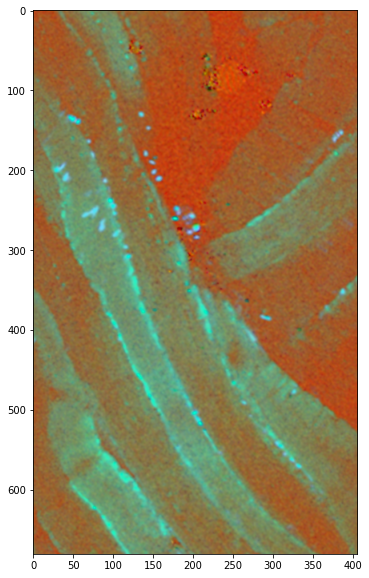

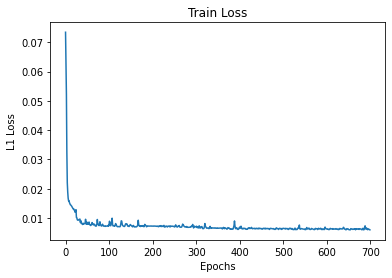

 70%|████████████████████████████            | 701/1000 [03:41<01:49,  2.73it/s]

Epoch: 701 	Training Loss: 0.006180


 70%|████████████████████████████            | 702/1000 [03:41<01:44,  2.86it/s]

Epoch: 702 	Training Loss: 0.006084


 70%|████████████████████████████            | 703/1000 [03:42<01:40,  2.95it/s]

Epoch: 703 	Training Loss: 0.006135


 70%|████████████████████████████▏           | 704/1000 [03:42<01:38,  3.02it/s]

Epoch: 704 	Training Loss: 0.006219


 70%|████████████████████████████▏           | 705/1000 [03:42<01:35,  3.08it/s]

Epoch: 705 	Training Loss: 0.006102


 71%|████████████████████████████▏           | 706/1000 [03:42<01:34,  3.11it/s]

Epoch: 706 	Training Loss: 0.006150


 71%|████████████████████████████▎           | 707/1000 [03:43<01:33,  3.14it/s]

Epoch: 707 	Training Loss: 0.006245


 71%|████████████████████████████▎           | 708/1000 [03:43<01:32,  3.15it/s]

Epoch: 708 	Training Loss: 0.006218


 71%|████████████████████████████▎           | 709/1000 [03:43<01:32,  3.16it/s]

Epoch: 709 	Training Loss: 0.006092


 71%|████████████████████████████▍           | 710/1000 [03:44<01:31,  3.17it/s]

Epoch: 710 	Training Loss: 0.006240


 71%|████████████████████████████▍           | 711/1000 [03:44<01:31,  3.17it/s]

Epoch: 711 	Training Loss: 0.006144


 71%|████████████████████████████▍           | 712/1000 [03:44<01:30,  3.18it/s]

Epoch: 712 	Training Loss: 0.006075


 71%|████████████████████████████▌           | 713/1000 [03:45<01:30,  3.18it/s]

Epoch: 713 	Training Loss: 0.005984


 71%|████████████████████████████▌           | 714/1000 [03:45<01:29,  3.19it/s]

Epoch: 714 	Training Loss: 0.006036


 72%|████████████████████████████▌           | 715/1000 [03:45<01:29,  3.19it/s]

Epoch: 715 	Training Loss: 0.006252


 72%|████████████████████████████▋           | 716/1000 [03:46<01:29,  3.19it/s]

Epoch: 716 	Training Loss: 0.006331


 72%|████████████████████████████▋           | 717/1000 [03:46<01:28,  3.19it/s]

Epoch: 717 	Training Loss: 0.006236


 72%|████████████████████████████▋           | 718/1000 [03:46<01:28,  3.19it/s]

Epoch: 718 	Training Loss: 0.005984


 72%|████████████████████████████▊           | 719/1000 [03:47<01:28,  3.19it/s]

Epoch: 719 	Training Loss: 0.006009


 72%|████████████████████████████▊           | 720/1000 [03:47<01:27,  3.19it/s]

Epoch: 720 	Training Loss: 0.006112


 72%|████████████████████████████▊           | 721/1000 [03:47<01:27,  3.20it/s]

Epoch: 721 	Training Loss: 0.006051


 72%|████████████████████████████▉           | 722/1000 [03:47<01:27,  3.19it/s]

Epoch: 722 	Training Loss: 0.006069


 72%|████████████████████████████▉           | 723/1000 [03:48<01:26,  3.19it/s]

Epoch: 723 	Training Loss: 0.006184


 72%|████████████████████████████▉           | 724/1000 [03:48<01:26,  3.19it/s]

Epoch: 724 	Training Loss: 0.006494


 72%|█████████████████████████████           | 725/1000 [03:48<01:26,  3.19it/s]

Epoch: 725 	Training Loss: 0.006267


 73%|█████████████████████████████           | 726/1000 [03:49<01:25,  3.19it/s]

Epoch: 726 	Training Loss: 0.006361


 73%|█████████████████████████████           | 727/1000 [03:49<01:25,  3.19it/s]

Epoch: 727 	Training Loss: 0.006069


 73%|█████████████████████████████           | 728/1000 [03:49<01:25,  3.19it/s]

Epoch: 728 	Training Loss: 0.006091


 73%|█████████████████████████████▏          | 729/1000 [03:50<01:24,  3.20it/s]

Epoch: 729 	Training Loss: 0.006110


 73%|█████████████████████████████▏          | 730/1000 [03:50<01:24,  3.19it/s]

Epoch: 730 	Training Loss: 0.006074


 73%|█████████████████████████████▏          | 731/1000 [03:50<01:24,  3.19it/s]

Epoch: 731 	Training Loss: 0.006011


 73%|█████████████████████████████▎          | 732/1000 [03:51<01:24,  3.19it/s]

Epoch: 732 	Training Loss: 0.006030


 73%|█████████████████████████████▎          | 733/1000 [03:51<01:23,  3.19it/s]

Epoch: 733 	Training Loss: 0.006080


 73%|█████████████████████████████▎          | 734/1000 [03:51<01:23,  3.20it/s]

Epoch: 734 	Training Loss: 0.006099


 74%|█████████████████████████████▍          | 735/1000 [03:52<01:22,  3.19it/s]

Epoch: 735 	Training Loss: 0.006115


 74%|█████████████████████████████▍          | 736/1000 [03:52<01:22,  3.19it/s]

Epoch: 736 	Training Loss: 0.006043


 74%|█████████████████████████████▍          | 737/1000 [03:52<01:22,  3.19it/s]

Epoch: 737 	Training Loss: 0.006257


 74%|█████████████████████████████▌          | 738/1000 [03:53<01:22,  3.19it/s]

Epoch: 738 	Training Loss: 0.006425


 74%|█████████████████████████████▌          | 739/1000 [03:53<01:21,  3.18it/s]

Epoch: 739 	Training Loss: 0.006328


 74%|█████████████████████████████▌          | 740/1000 [03:53<01:21,  3.19it/s]

Epoch: 740 	Training Loss: 0.006375


 74%|█████████████████████████████▋          | 741/1000 [03:53<01:21,  3.19it/s]

Epoch: 741 	Training Loss: 0.006312


 74%|█████████████████████████████▋          | 742/1000 [03:54<01:20,  3.19it/s]

Epoch: 742 	Training Loss: 0.006029


 74%|█████████████████████████████▋          | 743/1000 [03:54<01:20,  3.20it/s]

Epoch: 743 	Training Loss: 0.005989


 74%|█████████████████████████████▊          | 744/1000 [03:54<01:20,  3.20it/s]

Epoch: 744 	Training Loss: 0.006157


 74%|█████████████████████████████▊          | 745/1000 [03:55<01:19,  3.19it/s]

Epoch: 745 	Training Loss: 0.006238


 75%|█████████████████████████████▊          | 746/1000 [03:55<01:19,  3.19it/s]

Epoch: 746 	Training Loss: 0.006335


 75%|█████████████████████████████▉          | 747/1000 [03:55<01:19,  3.19it/s]

Epoch: 747 	Training Loss: 0.006376


 75%|█████████████████████████████▉          | 748/1000 [03:56<01:18,  3.19it/s]

Epoch: 748 	Training Loss: 0.006305


 75%|█████████████████████████████▉          | 749/1000 [03:56<01:18,  3.19it/s]

Epoch: 749 	Training Loss: 0.006218
Epoch: 750 	Training Loss: 0.006077


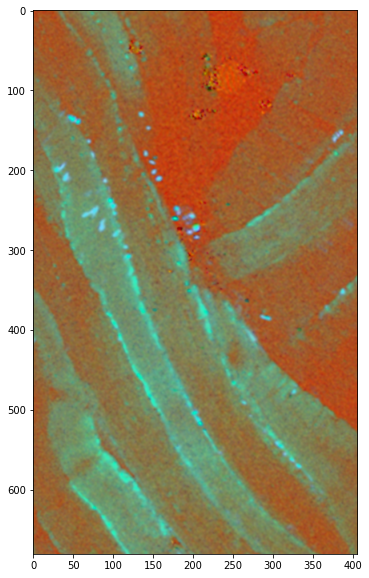

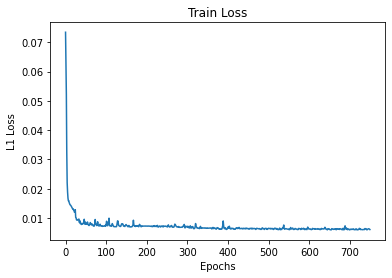

 75%|██████████████████████████████          | 751/1000 [03:57<01:31,  2.73it/s]

Epoch: 751 	Training Loss: 0.006164


 75%|██████████████████████████████          | 752/1000 [03:57<01:26,  2.86it/s]

Epoch: 752 	Training Loss: 0.006346


 75%|██████████████████████████████          | 753/1000 [03:57<01:23,  2.95it/s]

Epoch: 753 	Training Loss: 0.006228


 75%|██████████████████████████████▏         | 754/1000 [03:58<01:21,  3.02it/s]

Epoch: 754 	Training Loss: 0.006285


 76%|██████████████████████████████▏         | 755/1000 [03:58<01:19,  3.07it/s]

Epoch: 755 	Training Loss: 0.006364


 76%|██████████████████████████████▏         | 756/1000 [03:58<01:18,  3.10it/s]

Epoch: 756 	Training Loss: 0.006287


 76%|██████████████████████████████▎         | 757/1000 [03:59<01:17,  3.13it/s]

Epoch: 757 	Training Loss: 0.006186


 76%|██████████████████████████████▎         | 758/1000 [03:59<01:16,  3.15it/s]

Epoch: 758 	Training Loss: 0.006298


 76%|██████████████████████████████▎         | 759/1000 [03:59<01:16,  3.16it/s]

Epoch: 759 	Training Loss: 0.006260


 76%|██████████████████████████████▍         | 760/1000 [04:00<01:15,  3.18it/s]

Epoch: 760 	Training Loss: 0.006255


 76%|██████████████████████████████▍         | 761/1000 [04:00<01:15,  3.18it/s]

Epoch: 761 	Training Loss: 0.006214


 76%|██████████████████████████████▍         | 762/1000 [04:00<01:14,  3.18it/s]

Epoch: 762 	Training Loss: 0.006275


 76%|██████████████████████████████▌         | 763/1000 [04:01<01:14,  3.18it/s]

Epoch: 763 	Training Loss: 0.006105


 76%|██████████████████████████████▌         | 764/1000 [04:01<01:14,  3.19it/s]

Epoch: 764 	Training Loss: 0.006199


 76%|██████████████████████████████▌         | 765/1000 [04:01<01:13,  3.19it/s]

Epoch: 765 	Training Loss: 0.006338


 77%|██████████████████████████████▋         | 766/1000 [04:02<01:13,  3.19it/s]

Epoch: 766 	Training Loss: 0.006337


 77%|██████████████████████████████▋         | 767/1000 [04:02<01:13,  3.19it/s]

Epoch: 767 	Training Loss: 0.006112


 77%|██████████████████████████████▋         | 768/1000 [04:02<01:12,  3.19it/s]

Epoch: 768 	Training Loss: 0.006005


 77%|██████████████████████████████▊         | 769/1000 [04:02<01:12,  3.19it/s]

Epoch: 769 	Training Loss: 0.006014


 77%|██████████████████████████████▊         | 770/1000 [04:03<01:11,  3.20it/s]

Epoch: 770 	Training Loss: 0.006228


 77%|██████████████████████████████▊         | 771/1000 [04:03<01:11,  3.19it/s]

Epoch: 771 	Training Loss: 0.006375


 77%|██████████████████████████████▉         | 772/1000 [04:03<01:11,  3.19it/s]

Epoch: 772 	Training Loss: 0.006291


 77%|██████████████████████████████▉         | 773/1000 [04:04<01:11,  3.19it/s]

Epoch: 773 	Training Loss: 0.006751


 77%|██████████████████████████████▉         | 774/1000 [04:04<01:10,  3.19it/s]

Epoch: 774 	Training Loss: 0.006458


 78%|███████████████████████████████         | 775/1000 [04:04<01:10,  3.19it/s]

Epoch: 775 	Training Loss: 0.006156


 78%|███████████████████████████████         | 776/1000 [04:05<01:10,  3.19it/s]

Epoch: 776 	Training Loss: 0.006233


 78%|███████████████████████████████         | 777/1000 [04:05<01:09,  3.19it/s]

Epoch: 777 	Training Loss: 0.006554


 78%|███████████████████████████████         | 778/1000 [04:05<01:09,  3.19it/s]

Epoch: 778 	Training Loss: 0.006374


 78%|███████████████████████████████▏        | 779/1000 [04:06<01:09,  3.19it/s]

Epoch: 779 	Training Loss: 0.006105


 78%|███████████████████████████████▏        | 780/1000 [04:06<01:08,  3.19it/s]

Epoch: 780 	Training Loss: 0.006175


 78%|███████████████████████████████▏        | 781/1000 [04:06<01:08,  3.19it/s]

Epoch: 781 	Training Loss: 0.006193


 78%|███████████████████████████████▎        | 782/1000 [04:07<01:08,  3.19it/s]

Epoch: 782 	Training Loss: 0.006035


 78%|███████████████████████████████▎        | 783/1000 [04:07<01:08,  3.18it/s]

Epoch: 783 	Training Loss: 0.006070


 78%|███████████████████████████████▎        | 784/1000 [04:07<01:07,  3.19it/s]

Epoch: 784 	Training Loss: 0.006255


 78%|███████████████████████████████▍        | 785/1000 [04:07<01:07,  3.20it/s]

Epoch: 785 	Training Loss: 0.006280


 79%|███████████████████████████████▍        | 786/1000 [04:08<01:07,  3.19it/s]

Epoch: 786 	Training Loss: 0.006197


 79%|███████████████████████████████▍        | 787/1000 [04:08<01:06,  3.19it/s]

Epoch: 787 	Training Loss: 0.006085


 79%|███████████████████████████████▌        | 788/1000 [04:08<01:06,  3.19it/s]

Epoch: 788 	Training Loss: 0.006162


 79%|███████████████████████████████▌        | 789/1000 [04:09<01:06,  3.19it/s]

Epoch: 789 	Training Loss: 0.006080


 79%|███████████████████████████████▌        | 790/1000 [04:09<01:05,  3.19it/s]

Epoch: 790 	Training Loss: 0.006127


 79%|███████████████████████████████▋        | 791/1000 [04:09<01:05,  3.19it/s]

Epoch: 791 	Training Loss: 0.006314


 79%|███████████████████████████████▋        | 792/1000 [04:10<01:05,  3.18it/s]

Epoch: 792 	Training Loss: 0.006725


 79%|███████████████████████████████▋        | 793/1000 [04:10<01:04,  3.19it/s]

Epoch: 793 	Training Loss: 0.007175


 79%|███████████████████████████████▊        | 794/1000 [04:10<01:04,  3.19it/s]

Epoch: 794 	Training Loss: 0.006436


 80%|███████████████████████████████▊        | 795/1000 [04:11<01:04,  3.19it/s]

Epoch: 795 	Training Loss: 0.006113


 80%|███████████████████████████████▊        | 796/1000 [04:11<01:04,  3.19it/s]

Epoch: 796 	Training Loss: 0.005959


 80%|███████████████████████████████▉        | 797/1000 [04:11<01:03,  3.18it/s]

Epoch: 797 	Training Loss: 0.005962


 80%|███████████████████████████████▉        | 798/1000 [04:12<01:03,  3.18it/s]

Epoch: 798 	Training Loss: 0.005935


 80%|███████████████████████████████▉        | 799/1000 [04:12<01:03,  3.19it/s]

Epoch: 799 	Training Loss: 0.005966
Epoch: 800 	Training Loss: 0.005992


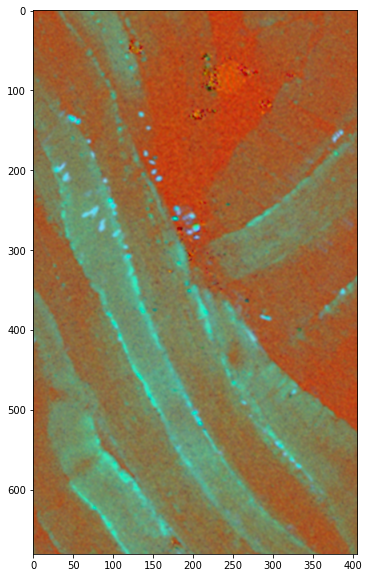

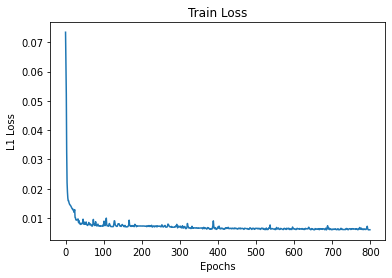

 80%|████████████████████████████████        | 801/1000 [04:13<01:12,  2.73it/s]

Epoch: 801 	Training Loss: 0.006004


 80%|████████████████████████████████        | 802/1000 [04:13<01:09,  2.86it/s]

Epoch: 802 	Training Loss: 0.005967


 80%|████████████████████████████████        | 803/1000 [04:13<01:06,  2.95it/s]

Epoch: 803 	Training Loss: 0.005903


 80%|████████████████████████████████▏       | 804/1000 [04:14<01:04,  3.02it/s]

Epoch: 804 	Training Loss: 0.006213


 80%|████████████████████████████████▏       | 805/1000 [04:14<01:03,  3.07it/s]

Epoch: 805 	Training Loss: 0.006337


 81%|████████████████████████████████▏       | 806/1000 [04:14<01:02,  3.11it/s]

Epoch: 806 	Training Loss: 0.006371


 81%|████████████████████████████████▎       | 807/1000 [04:15<01:01,  3.14it/s]

Epoch: 807 	Training Loss: 0.006137


 81%|████████████████████████████████▎       | 808/1000 [04:15<01:00,  3.15it/s]

Epoch: 808 	Training Loss: 0.006062


 81%|████████████████████████████████▎       | 809/1000 [04:15<01:00,  3.16it/s]

Epoch: 809 	Training Loss: 0.006263


 81%|████████████████████████████████▍       | 810/1000 [04:16<00:59,  3.17it/s]

Epoch: 810 	Training Loss: 0.006252


 81%|████████████████████████████████▍       | 811/1000 [04:16<00:59,  3.18it/s]

Epoch: 811 	Training Loss: 0.006052


 81%|████████████████████████████████▍       | 812/1000 [04:16<00:59,  3.18it/s]

Epoch: 812 	Training Loss: 0.006014


 81%|████████████████████████████████▌       | 813/1000 [04:17<00:58,  3.18it/s]

Epoch: 813 	Training Loss: 0.005986


 81%|████████████████████████████████▌       | 814/1000 [04:17<00:58,  3.18it/s]

Epoch: 814 	Training Loss: 0.005967


 82%|████████████████████████████████▌       | 815/1000 [04:17<00:57,  3.19it/s]

Epoch: 815 	Training Loss: 0.006088


 82%|████████████████████████████████▋       | 816/1000 [04:17<00:57,  3.19it/s]

Epoch: 816 	Training Loss: 0.006207


 82%|████████████████████████████████▋       | 817/1000 [04:18<00:57,  3.19it/s]

Epoch: 817 	Training Loss: 0.006043


 82%|████████████████████████████████▋       | 818/1000 [04:18<00:56,  3.20it/s]

Epoch: 818 	Training Loss: 0.006022


 82%|████████████████████████████████▊       | 819/1000 [04:18<00:56,  3.20it/s]

Epoch: 819 	Training Loss: 0.006368


 82%|████████████████████████████████▊       | 820/1000 [04:19<00:56,  3.19it/s]

Epoch: 820 	Training Loss: 0.006326


 82%|████████████████████████████████▊       | 821/1000 [04:19<00:56,  3.19it/s]

Epoch: 821 	Training Loss: 0.006212


 82%|████████████████████████████████▉       | 822/1000 [04:19<00:55,  3.19it/s]

Epoch: 822 	Training Loss: 0.006288


 82%|████████████████████████████████▉       | 823/1000 [04:20<00:55,  3.18it/s]

Epoch: 823 	Training Loss: 0.006061


 82%|████████████████████████████████▉       | 824/1000 [04:20<00:55,  3.19it/s]

Epoch: 824 	Training Loss: 0.005974


 82%|█████████████████████████████████       | 825/1000 [04:20<00:54,  3.19it/s]

Epoch: 825 	Training Loss: 0.006142


 83%|█████████████████████████████████       | 826/1000 [04:21<00:54,  3.19it/s]

Epoch: 826 	Training Loss: 0.006238


 83%|█████████████████████████████████       | 827/1000 [04:21<00:54,  3.19it/s]

Epoch: 827 	Training Loss: 0.006134


 83%|█████████████████████████████████       | 828/1000 [04:21<00:53,  3.19it/s]

Epoch: 828 	Training Loss: 0.006239


 83%|█████████████████████████████████▏      | 829/1000 [04:22<00:53,  3.19it/s]

Epoch: 829 	Training Loss: 0.006245


 83%|█████████████████████████████████▏      | 830/1000 [04:22<00:53,  3.19it/s]

Epoch: 830 	Training Loss: 0.006241


 83%|█████████████████████████████████▏      | 831/1000 [04:22<00:52,  3.19it/s]

Epoch: 831 	Training Loss: 0.006248


 83%|█████████████████████████████████▎      | 832/1000 [04:22<00:52,  3.19it/s]

Epoch: 832 	Training Loss: 0.006248


 83%|█████████████████████████████████▎      | 833/1000 [04:23<00:52,  3.19it/s]

Epoch: 833 	Training Loss: 0.006176


 83%|█████████████████████████████████▎      | 834/1000 [04:23<00:52,  3.19it/s]

Epoch: 834 	Training Loss: 0.006247


 84%|█████████████████████████████████▍      | 835/1000 [04:23<00:51,  3.19it/s]

Epoch: 835 	Training Loss: 0.006164


 84%|█████████████████████████████████▍      | 836/1000 [04:24<00:51,  3.20it/s]

Epoch: 836 	Training Loss: 0.005990


 84%|█████████████████████████████████▍      | 837/1000 [04:24<00:51,  3.19it/s]

Epoch: 837 	Training Loss: 0.005924


 84%|█████████████████████████████████▌      | 838/1000 [04:24<00:50,  3.19it/s]

Epoch: 838 	Training Loss: 0.006011


 84%|█████████████████████████████████▌      | 839/1000 [04:25<00:50,  3.19it/s]

Epoch: 839 	Training Loss: 0.005987


 84%|█████████████████████████████████▌      | 840/1000 [04:25<00:50,  3.18it/s]

Epoch: 840 	Training Loss: 0.006227


 84%|█████████████████████████████████▋      | 841/1000 [04:25<00:49,  3.19it/s]

Epoch: 841 	Training Loss: 0.006364


 84%|█████████████████████████████████▋      | 842/1000 [04:26<00:49,  3.20it/s]

Epoch: 842 	Training Loss: 0.006212


 84%|█████████████████████████████████▋      | 843/1000 [04:26<00:49,  3.19it/s]

Epoch: 843 	Training Loss: 0.006303


 84%|█████████████████████████████████▊      | 844/1000 [04:26<00:48,  3.19it/s]

Epoch: 844 	Training Loss: 0.006132


 84%|█████████████████████████████████▊      | 845/1000 [04:27<00:48,  3.19it/s]

Epoch: 845 	Training Loss: 0.005939


 85%|█████████████████████████████████▊      | 846/1000 [04:27<00:48,  3.19it/s]

Epoch: 846 	Training Loss: 0.006203


 85%|█████████████████████████████████▉      | 847/1000 [04:27<00:47,  3.19it/s]

Epoch: 847 	Training Loss: 0.006250


 85%|█████████████████████████████████▉      | 848/1000 [04:27<00:47,  3.19it/s]

Epoch: 848 	Training Loss: 0.006254


 85%|█████████████████████████████████▉      | 849/1000 [04:28<00:47,  3.19it/s]

Epoch: 849 	Training Loss: 0.006133
Epoch: 850 	Training Loss: 0.005993


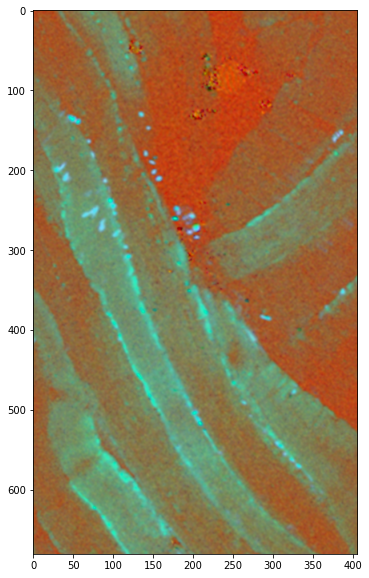

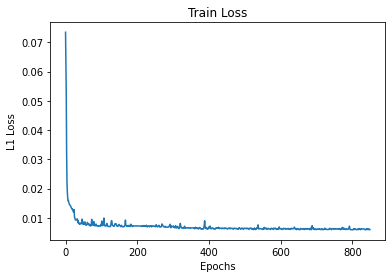

 85%|██████████████████████████████████      | 851/1000 [04:29<00:54,  2.74it/s]

Epoch: 851 	Training Loss: 0.006238


 85%|██████████████████████████████████      | 852/1000 [04:29<00:51,  2.87it/s]

Epoch: 852 	Training Loss: 0.006263


 85%|██████████████████████████████████      | 853/1000 [04:29<00:49,  2.96it/s]

Epoch: 853 	Training Loss: 0.006080


 85%|██████████████████████████████████▏     | 854/1000 [04:30<00:48,  3.02it/s]

Epoch: 854 	Training Loss: 0.006097


 86%|██████████████████████████████████▏     | 855/1000 [04:30<00:47,  3.07it/s]

Epoch: 855 	Training Loss: 0.006269


 86%|██████████████████████████████████▏     | 856/1000 [04:30<00:46,  3.11it/s]

Epoch: 856 	Training Loss: 0.006242


 86%|██████████████████████████████████▎     | 857/1000 [04:31<00:45,  3.14it/s]

Epoch: 857 	Training Loss: 0.006153


 86%|██████████████████████████████████▎     | 858/1000 [04:31<00:45,  3.15it/s]

Epoch: 858 	Training Loss: 0.006145


 86%|██████████████████████████████████▎     | 859/1000 [04:31<00:44,  3.16it/s]

Epoch: 859 	Training Loss: 0.006191


 86%|██████████████████████████████████▍     | 860/1000 [04:31<00:44,  3.17it/s]

Epoch: 860 	Training Loss: 0.006242


 86%|██████████████████████████████████▍     | 861/1000 [04:32<00:43,  3.18it/s]

Epoch: 861 	Training Loss: 0.006165


 86%|██████████████████████████████████▍     | 862/1000 [04:32<00:43,  3.18it/s]

Epoch: 862 	Training Loss: 0.006058


 86%|██████████████████████████████████▌     | 863/1000 [04:32<00:43,  3.18it/s]

Epoch: 863 	Training Loss: 0.006277


 86%|██████████████████████████████████▌     | 864/1000 [04:33<00:42,  3.18it/s]

Epoch: 864 	Training Loss: 0.006255


 86%|██████████████████████████████████▌     | 865/1000 [04:33<00:42,  3.18it/s]

Epoch: 865 	Training Loss: 0.006064


 87%|██████████████████████████████████▋     | 866/1000 [04:33<00:42,  3.18it/s]

Epoch: 866 	Training Loss: 0.006028


 87%|██████████████████████████████████▋     | 867/1000 [04:34<00:41,  3.19it/s]

Epoch: 867 	Training Loss: 0.005971


 87%|██████████████████████████████████▋     | 868/1000 [04:34<00:41,  3.19it/s]

Epoch: 868 	Training Loss: 0.005963


 87%|██████████████████████████████████▊     | 869/1000 [04:34<00:41,  3.19it/s]

Epoch: 869 	Training Loss: 0.005884


 87%|██████████████████████████████████▊     | 870/1000 [04:35<00:40,  3.19it/s]

Epoch: 870 	Training Loss: 0.006037


 87%|██████████████████████████████████▊     | 871/1000 [04:35<00:40,  3.19it/s]

Epoch: 871 	Training Loss: 0.006169


 87%|██████████████████████████████████▉     | 872/1000 [04:35<00:40,  3.18it/s]

Epoch: 872 	Training Loss: 0.006357


 87%|██████████████████████████████████▉     | 873/1000 [04:36<00:39,  3.19it/s]

Epoch: 873 	Training Loss: 0.006297


 87%|██████████████████████████████████▉     | 874/1000 [04:36<00:39,  3.19it/s]

Epoch: 874 	Training Loss: 0.005993


 88%|███████████████████████████████████     | 875/1000 [04:36<00:39,  3.19it/s]

Epoch: 875 	Training Loss: 0.006244


 88%|███████████████████████████████████     | 876/1000 [04:36<00:38,  3.19it/s]

Epoch: 876 	Training Loss: 0.006177


 88%|███████████████████████████████████     | 877/1000 [04:37<00:38,  3.18it/s]

Epoch: 877 	Training Loss: 0.006007


 88%|███████████████████████████████████     | 878/1000 [04:37<00:38,  3.18it/s]

Epoch: 878 	Training Loss: 0.005979


 88%|███████████████████████████████████▏    | 879/1000 [04:37<00:38,  3.18it/s]

Epoch: 879 	Training Loss: 0.005974


 88%|███████████████████████████████████▏    | 880/1000 [04:38<00:37,  3.19it/s]

Epoch: 880 	Training Loss: 0.006011


 88%|███████████████████████████████████▏    | 881/1000 [04:38<00:37,  3.19it/s]

Epoch: 881 	Training Loss: 0.005958


 88%|███████████████████████████████████▎    | 882/1000 [04:38<00:36,  3.19it/s]

Epoch: 882 	Training Loss: 0.006149


 88%|███████████████████████████████████▎    | 883/1000 [04:39<00:36,  3.20it/s]

Epoch: 883 	Training Loss: 0.006381


 88%|███████████████████████████████████▎    | 884/1000 [04:39<00:36,  3.19it/s]

Epoch: 884 	Training Loss: 0.006286


 88%|███████████████████████████████████▍    | 885/1000 [04:39<00:36,  3.19it/s]

Epoch: 885 	Training Loss: 0.006277


 89%|███████████████████████████████████▍    | 886/1000 [04:40<00:35,  3.19it/s]

Epoch: 886 	Training Loss: 0.006292


 89%|███████████████████████████████████▍    | 887/1000 [04:40<00:35,  3.18it/s]

Epoch: 887 	Training Loss: 0.006058


 89%|███████████████████████████████████▌    | 888/1000 [04:40<00:35,  3.19it/s]

Epoch: 888 	Training Loss: 0.006044


 89%|███████████████████████████████████▌    | 889/1000 [04:41<00:34,  3.19it/s]

Epoch: 889 	Training Loss: 0.006023


 89%|███████████████████████████████████▌    | 890/1000 [04:41<00:34,  3.19it/s]

Epoch: 890 	Training Loss: 0.006429


 89%|███████████████████████████████████▋    | 891/1000 [04:41<00:34,  3.19it/s]

Epoch: 891 	Training Loss: 0.006814


 89%|███████████████████████████████████▋    | 892/1000 [04:42<00:33,  3.18it/s]

Epoch: 892 	Training Loss: 0.007453


 89%|███████████████████████████████████▋    | 893/1000 [04:42<00:33,  3.19it/s]

Epoch: 893 	Training Loss: 0.006295


 89%|███████████████████████████████████▊    | 894/1000 [04:42<00:33,  3.20it/s]

Epoch: 894 	Training Loss: 0.006169


 90%|███████████████████████████████████▊    | 895/1000 [04:42<00:32,  3.19it/s]

Epoch: 895 	Training Loss: 0.006032


 90%|███████████████████████████████████▊    | 896/1000 [04:43<00:32,  3.19it/s]

Epoch: 896 	Training Loss: 0.005962


 90%|███████████████████████████████████▉    | 897/1000 [04:43<00:32,  3.19it/s]

Epoch: 897 	Training Loss: 0.005977


 90%|███████████████████████████████████▉    | 898/1000 [04:43<00:32,  3.19it/s]

Epoch: 898 	Training Loss: 0.006039


 90%|███████████████████████████████████▉    | 899/1000 [04:44<00:31,  3.18it/s]

Epoch: 899 	Training Loss: 0.006104
Epoch: 900 	Training Loss: 0.005937


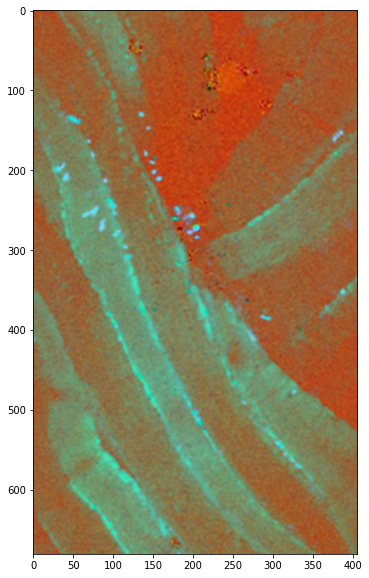

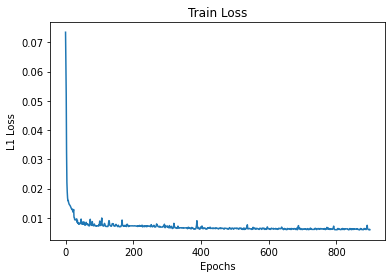

 90%|████████████████████████████████████    | 901/1000 [04:45<00:36,  2.74it/s]

Epoch: 901 	Training Loss: 0.006139


 90%|████████████████████████████████████    | 902/1000 [04:45<00:34,  2.86it/s]

Epoch: 902 	Training Loss: 0.006149


 90%|████████████████████████████████████    | 903/1000 [04:45<00:32,  2.96it/s]

Epoch: 903 	Training Loss: 0.006204


 90%|████████████████████████████████████▏   | 904/1000 [04:46<00:31,  3.02it/s]

Epoch: 904 	Training Loss: 0.006316


 90%|████████████████████████████████████▏   | 905/1000 [04:46<00:30,  3.07it/s]

Epoch: 905 	Training Loss: 0.006232


 91%|████████████████████████████████████▏   | 906/1000 [04:46<00:30,  3.10it/s]

Epoch: 906 	Training Loss: 0.006101


 91%|████████████████████████████████████▎   | 907/1000 [04:46<00:29,  3.13it/s]

Epoch: 907 	Training Loss: 0.006002


 91%|████████████████████████████████████▎   | 908/1000 [04:47<00:29,  3.15it/s]

Epoch: 908 	Training Loss: 0.006184


 91%|████████████████████████████████████▎   | 909/1000 [04:47<00:28,  3.16it/s]

Epoch: 909 	Training Loss: 0.006709


 91%|████████████████████████████████████▍   | 910/1000 [04:47<00:28,  3.17it/s]

Epoch: 910 	Training Loss: 0.006411


 91%|████████████████████████████████████▍   | 911/1000 [04:48<00:28,  3.17it/s]

Epoch: 911 	Training Loss: 0.006087


 91%|████████████████████████████████████▍   | 912/1000 [04:48<00:27,  3.18it/s]

Epoch: 912 	Training Loss: 0.006027


 91%|████████████████████████████████████▌   | 913/1000 [04:48<00:27,  3.18it/s]

Epoch: 913 	Training Loss: 0.006084


 91%|████████████████████████████████████▌   | 914/1000 [04:49<00:27,  3.18it/s]

Epoch: 914 	Training Loss: 0.006228


 92%|████████████████████████████████████▌   | 915/1000 [04:49<00:26,  3.18it/s]

Epoch: 915 	Training Loss: 0.006170


 92%|████████████████████████████████████▋   | 916/1000 [04:49<00:26,  3.18it/s]

Epoch: 916 	Training Loss: 0.006137


 92%|████████████████████████████████████▋   | 917/1000 [04:50<00:26,  3.18it/s]

Epoch: 917 	Training Loss: 0.006045


 92%|████████████████████████████████████▋   | 918/1000 [04:50<00:25,  3.19it/s]

Epoch: 918 	Training Loss: 0.006162


 92%|████████████████████████████████████▊   | 919/1000 [04:50<00:25,  3.19it/s]

Epoch: 919 	Training Loss: 0.006131


 92%|████████████████████████████████████▊   | 920/1000 [04:51<00:25,  3.19it/s]

Epoch: 920 	Training Loss: 0.006139


 92%|████████████████████████████████████▊   | 921/1000 [04:51<00:24,  3.19it/s]

Epoch: 921 	Training Loss: 0.006173


 92%|████████████████████████████████████▉   | 922/1000 [04:51<00:24,  3.19it/s]

Epoch: 922 	Training Loss: 0.005979


 92%|████████████████████████████████████▉   | 923/1000 [04:51<00:24,  3.19it/s]

Epoch: 923 	Training Loss: 0.005869


 92%|████████████████████████████████████▉   | 924/1000 [04:52<00:23,  3.19it/s]

Epoch: 924 	Training Loss: 0.006113


 92%|█████████████████████████████████████   | 925/1000 [04:52<00:23,  3.19it/s]

Epoch: 925 	Training Loss: 0.006189


 93%|█████████████████████████████████████   | 926/1000 [04:52<00:23,  3.19it/s]

Epoch: 926 	Training Loss: 0.006190


 93%|█████████████████████████████████████   | 927/1000 [04:53<00:22,  3.19it/s]

Epoch: 927 	Training Loss: 0.006123


 93%|█████████████████████████████████████   | 928/1000 [04:53<00:22,  3.19it/s]

Epoch: 928 	Training Loss: 0.006064


 93%|█████████████████████████████████████▏  | 929/1000 [04:53<00:22,  3.19it/s]

Epoch: 929 	Training Loss: 0.006287


 93%|█████████████████████████████████████▏  | 930/1000 [04:54<00:21,  3.18it/s]

Epoch: 930 	Training Loss: 0.006226


 93%|█████████████████████████████████████▏  | 931/1000 [04:54<00:21,  3.19it/s]

Epoch: 931 	Training Loss: 0.006266


 93%|█████████████████████████████████████▎  | 932/1000 [04:54<00:21,  3.19it/s]

Epoch: 932 	Training Loss: 0.006506


 93%|█████████████████████████████████████▎  | 933/1000 [04:55<00:20,  3.19it/s]

Epoch: 933 	Training Loss: 0.006199


 93%|█████████████████████████████████████▎  | 934/1000 [04:55<00:20,  3.19it/s]

Epoch: 934 	Training Loss: 0.006044


 94%|█████████████████████████████████████▍  | 935/1000 [04:55<00:20,  3.20it/s]

Epoch: 935 	Training Loss: 0.006075


 94%|█████████████████████████████████████▍  | 936/1000 [04:56<00:20,  3.20it/s]

Epoch: 936 	Training Loss: 0.005958


 94%|█████████████████████████████████████▍  | 937/1000 [04:56<00:19,  3.19it/s]

Epoch: 937 	Training Loss: 0.006119


 94%|█████████████████████████████████████▌  | 938/1000 [04:56<00:19,  3.19it/s]

Epoch: 938 	Training Loss: 0.006130


 94%|█████████████████████████████████████▌  | 939/1000 [04:56<00:19,  3.19it/s]

Epoch: 939 	Training Loss: 0.005991


 94%|█████████████████████████████████████▌  | 940/1000 [04:57<00:18,  3.19it/s]

Epoch: 940 	Training Loss: 0.006189


 94%|█████████████████████████████████████▋  | 941/1000 [04:57<00:18,  3.19it/s]

Epoch: 941 	Training Loss: 0.006226


 94%|█████████████████████████████████████▋  | 942/1000 [04:57<00:18,  3.19it/s]

Epoch: 942 	Training Loss: 0.006073


 94%|█████████████████████████████████████▋  | 943/1000 [04:58<00:17,  3.19it/s]

Epoch: 943 	Training Loss: 0.006132


 94%|█████████████████████████████████████▊  | 944/1000 [04:58<00:17,  3.19it/s]

Epoch: 944 	Training Loss: 0.006112


 94%|█████████████████████████████████████▊  | 945/1000 [04:58<00:17,  3.18it/s]

Epoch: 945 	Training Loss: 0.006169


 95%|█████████████████████████████████████▊  | 946/1000 [04:59<00:16,  3.18it/s]

Epoch: 946 	Training Loss: 0.006078


 95%|█████████████████████████████████████▉  | 947/1000 [04:59<00:16,  3.19it/s]

Epoch: 947 	Training Loss: 0.005901


 95%|█████████████████████████████████████▉  | 948/1000 [04:59<00:16,  3.19it/s]

Epoch: 948 	Training Loss: 0.006154


 95%|█████████████████████████████████████▉  | 949/1000 [05:00<00:15,  3.19it/s]

Epoch: 949 	Training Loss: 0.006184
Epoch: 950 	Training Loss: 0.006141


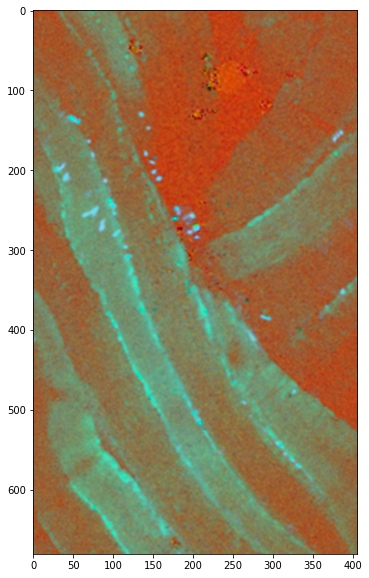

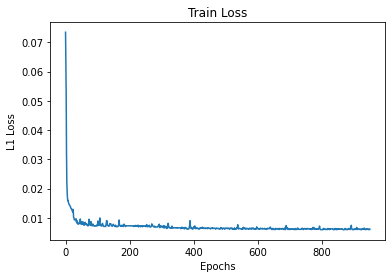

 95%|██████████████████████████████████████  | 951/1000 [05:01<00:17,  2.75it/s]

Epoch: 951 	Training Loss: 0.006111


 95%|██████████████████████████████████████  | 952/1000 [05:01<00:16,  2.87it/s]

Epoch: 952 	Training Loss: 0.006140


 95%|██████████████████████████████████████  | 953/1000 [05:01<00:15,  2.96it/s]

Epoch: 953 	Training Loss: 0.006202


 95%|██████████████████████████████████████▏ | 954/1000 [05:01<00:15,  3.02it/s]

Epoch: 954 	Training Loss: 0.006106


 96%|██████████████████████████████████████▏ | 955/1000 [05:02<00:14,  3.08it/s]

Epoch: 955 	Training Loss: 0.006014


 96%|██████████████████████████████████████▏ | 956/1000 [05:02<00:14,  3.11it/s]

Epoch: 956 	Training Loss: 0.006010


 96%|██████████████████████████████████████▎ | 957/1000 [05:02<00:13,  3.13it/s]

Epoch: 957 	Training Loss: 0.006112


 96%|██████████████████████████████████████▎ | 958/1000 [05:03<00:13,  3.15it/s]

Epoch: 958 	Training Loss: 0.006165


 96%|██████████████████████████████████████▎ | 959/1000 [05:03<00:12,  3.16it/s]

Epoch: 959 	Training Loss: 0.006273


 96%|██████████████████████████████████████▍ | 960/1000 [05:03<00:12,  3.17it/s]

Epoch: 960 	Training Loss: 0.006131


 96%|██████████████████████████████████████▍ | 961/1000 [05:04<00:12,  3.18it/s]

Epoch: 961 	Training Loss: 0.006259


 96%|██████████████████████████████████████▍ | 962/1000 [05:04<00:11,  3.18it/s]

Epoch: 962 	Training Loss: 0.006224


 96%|██████████████████████████████████████▌ | 963/1000 [05:04<00:11,  3.18it/s]

Epoch: 963 	Training Loss: 0.006137


 96%|██████████████████████████████████████▌ | 964/1000 [05:05<00:11,  3.18it/s]

Epoch: 964 	Training Loss: 0.006255


 96%|██████████████████████████████████████▌ | 965/1000 [05:05<00:10,  3.19it/s]

Epoch: 965 	Training Loss: 0.006185


 97%|██████████████████████████████████████▋ | 966/1000 [05:05<00:10,  3.19it/s]

Epoch: 966 	Training Loss: 0.006021


 97%|██████████████████████████████████████▋ | 967/1000 [05:06<00:10,  3.19it/s]

Epoch: 967 	Training Loss: 0.005927


 97%|██████████████████████████████████████▋ | 968/1000 [05:06<00:10,  3.19it/s]

Epoch: 968 	Training Loss: 0.006153


 97%|██████████████████████████████████████▊ | 969/1000 [05:06<00:09,  3.19it/s]

Epoch: 969 	Training Loss: 0.006098


 97%|██████████████████████████████████████▊ | 970/1000 [05:06<00:09,  3.19it/s]

Epoch: 970 	Training Loss: 0.006001


 97%|██████████████████████████████████████▊ | 971/1000 [05:07<00:09,  3.18it/s]

Epoch: 971 	Training Loss: 0.005975


 97%|██████████████████████████████████████▉ | 972/1000 [05:07<00:08,  3.18it/s]

Epoch: 972 	Training Loss: 0.006112


 97%|██████████████████████████████████████▉ | 973/1000 [05:07<00:08,  3.18it/s]

Epoch: 973 	Training Loss: 0.006183


 97%|██████████████████████████████████████▉ | 974/1000 [05:08<00:08,  3.18it/s]

Epoch: 974 	Training Loss: 0.006072


 98%|███████████████████████████████████████ | 975/1000 [05:08<00:07,  3.18it/s]

Epoch: 975 	Training Loss: 0.006178


 98%|███████████████████████████████████████ | 976/1000 [05:08<00:07,  3.19it/s]

Epoch: 976 	Training Loss: 0.006149


 98%|███████████████████████████████████████ | 977/1000 [05:09<00:07,  3.19it/s]

Epoch: 977 	Training Loss: 0.006272


 98%|███████████████████████████████████████ | 978/1000 [05:09<00:06,  3.19it/s]

Epoch: 978 	Training Loss: 0.006192


 98%|███████████████████████████████████████▏| 979/1000 [05:09<00:06,  3.19it/s]

Epoch: 979 	Training Loss: 0.006038


 98%|███████████████████████████████████████▏| 980/1000 [05:10<00:06,  3.18it/s]

Epoch: 980 	Training Loss: 0.006126


 98%|███████████████████████████████████████▏| 981/1000 [05:10<00:05,  3.18it/s]

Epoch: 981 	Training Loss: 0.006147


 98%|███████████████████████████████████████▎| 982/1000 [05:10<00:05,  3.18it/s]

Epoch: 982 	Training Loss: 0.006208


 98%|███████████████████████████████████████▎| 983/1000 [05:11<00:05,  3.19it/s]

Epoch: 983 	Training Loss: 0.006098


 98%|███████████████████████████████████████▎| 984/1000 [05:11<00:05,  3.19it/s]

Epoch: 984 	Training Loss: 0.006065


 98%|███████████████████████████████████████▍| 985/1000 [05:11<00:04,  3.19it/s]

Epoch: 985 	Training Loss: 0.006149


 99%|███████████████████████████████████████▍| 986/1000 [05:11<00:04,  3.19it/s]

Epoch: 986 	Training Loss: 0.006024


 99%|███████████████████████████████████████▍| 987/1000 [05:12<00:04,  3.19it/s]

Epoch: 987 	Training Loss: 0.005917


 99%|███████████████████████████████████████▌| 988/1000 [05:12<00:03,  3.19it/s]

Epoch: 988 	Training Loss: 0.006142


 99%|███████████████████████████████████████▌| 989/1000 [05:12<00:03,  3.20it/s]

Epoch: 989 	Training Loss: 0.006319


 99%|███████████████████████████████████████▌| 990/1000 [05:13<00:03,  3.19it/s]

Epoch: 990 	Training Loss: 0.006148


 99%|███████████████████████████████████████▋| 991/1000 [05:13<00:02,  3.19it/s]

Epoch: 991 	Training Loss: 0.006145


 99%|███████████████████████████████████████▋| 992/1000 [05:13<00:02,  3.19it/s]

Epoch: 992 	Training Loss: 0.006220


 99%|███████████████████████████████████████▋| 993/1000 [05:14<00:02,  3.18it/s]

Epoch: 993 	Training Loss: 0.006120


 99%|███████████████████████████████████████▊| 994/1000 [05:14<00:01,  3.18it/s]

Epoch: 994 	Training Loss: 0.005963


100%|███████████████████████████████████████▊| 995/1000 [05:14<00:01,  3.18it/s]

Epoch: 995 	Training Loss: 0.005946


100%|███████████████████████████████████████▊| 996/1000 [05:15<00:01,  3.19it/s]

Epoch: 996 	Training Loss: 0.005946


100%|███████████████████████████████████████▉| 997/1000 [05:15<00:00,  3.19it/s]

Epoch: 997 	Training Loss: 0.006057


100%|███████████████████████████████████████▉| 998/1000 [05:15<00:00,  3.19it/s]

Epoch: 998 	Training Loss: 0.006383


100%|███████████████████████████████████████▉| 999/1000 [05:16<00:00,  3.19it/s]

Epoch: 999 	Training Loss: 0.006218
Epoch: 1000 	Training Loss: 0.006112


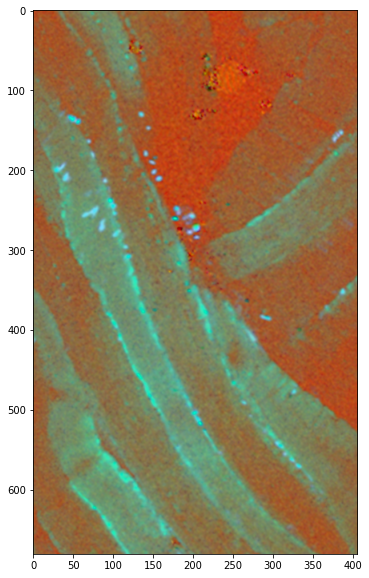

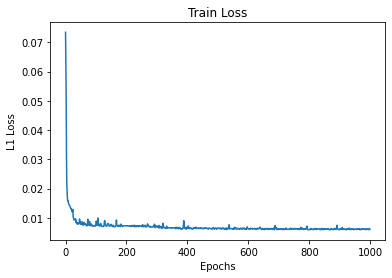

100%|███████████████████████████████████████| 1000/1000 [05:16<00:00,  3.16it/s]


In [12]:
n_epochs = 1000
L1_loss = []
z_imgs = []

for epoch in tqdm(range(1, n_epochs+1)):
    # monitor training loss
    train_loss = 0.0

    #Training
    for images in img_stack:
        images = images[None, :]
        image_x_p = torch.permute(images, (0, 3, 1, 2))
        image_x_p = image_x_p.to(device)
        optimizer.zero_grad()         
        outputs = model(image_x_p)
        loss = criterion(outputs, image_x_p)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*image_x_p.size(0)
          
    train_loss = train_loss/len(img_stack)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    L1_loss.append(train_loss)
    
    if epoch%50 == 0:
        # visualize latent space
        temp_img = visualize_z(3)
        z_imgs.append(temp_img)
        # plot loss curve
        plt.plot(L1_loss)
        plt.title('Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('L1 Loss')
        plt.show()

# Analyze latent space images

In [ ]:
z_imgs = np.asarray(z_imgs)
print(z_imgs.shape)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(z_imgs[39,:,:,:])
plt.show()

In [ ]:
# iterate through the latent space image stack and save the images
n_count = 0
for img in z_imgs:
    io.imsave('img' + str(n_count) + '.png', img)
    n_count = n_count + 1

In [ ]:
# use the saved latent space images to create a movie
image_folder = '/home/arya1080/python_projects/CNN_TAM'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()